<div class="alert alert-success" style = "border-radius:10px;border-width:3px;border-color:white;font-family:Verdana,sans-serif;font-size:16px;">
<h2>Mixture Density Networks (MDN) for distribution and uncertainty estimation </h2>

This material is copyright Axel Brando and made available under the Creative Commons Attribution-ShareAlike 4.0 International License (http://creativecommons.org/licenses/by-sa/4.0/). Code is also made available under the Apache Version 2.0 License (https://www.apache.org/licenses/LICENSE-2.0). 

Please, to use this material and code follow the instructions explained in the main repository [https://github.com/axelbrando/Mixture-Density-Networks-for-distribution-and-uncertainty-estimation](https://github.com/axelbrando/Mixture-Density-Networks-for-distribution-and-uncertainty-estimation#bibtex-reference-format-for-citation)

<div class="alert alert-info" style = "border-radius:10px;border-width:3px;border-color:white;font-family:Verdana,sans-serif;font-size:16px;">
<h3>Trying to predict uncertainty by using Deep Ensemble</h3>
Below we will show a implementation of the following points:
<ul>
    <li>The article of Lakshminarayanan et al. (DeepMind London) *Simple and Scalable Predictive Uncertainty Estimation using Deep Ensembles.*</li>
    <li>The visualisation of the an increasingly more and more adversarial data set to see if the $\sigma$ increases.</li>
    <li>With the other tricks described in the main page of the repository https://github.com/axelbrando/Mixture-Density-Networks-for-distribution-and-uncertainty-estimation</li>
</ul>
</div>

In [1]:
import tensorflow as tf
tf.python.control_flow_ops = tf

#config = tf.ConfigProto()
#config.gpu_options.allow_growth=True
#sess = tf.Session(config=config)

from keras import backend as K

import os
import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
import random
from datetime import datetime

Using TensorFlow backend.


### We load our dataset
Because our dataset is private we will only expose a dummy code

In [2]:
X = np.load('Normalised-X_train.npy')
y = np.load('y_train.npy')
X_val = np.load('Normalised-X_val.npy')
y_val = np.load('y_val.npy')
X_orig = np.load('Original-X_train.npy')
X_val_orig = np.load('Original-X_val.npy')

In [3]:
from keras.models import Sequential,Graph
from keras.layers.core import Dense, Dropout
from keras.callbacks import History
from keras.layers.recurrent import LSTM
from keras.models import model_from_json
from keras.regularizers import l2, activity_l2

from keras.objectives import mean_absolute_error

c = 1 #The number of outputs we want to predict
m = 1 #The number of distributions we want to use in the mixture

#Note: The output size will be (c + 2) * m

def log_sum_exp(x, axis=None):
    """Log-sum-exp trick implementation"""
    x_max = K.max(x, axis=axis, keepdims=True)
    return K.log(K.sum(K.exp(x - x_max), 
                       axis=axis, keepdims=True))+x_max


def mean_log_Gaussian_like(y_true, parameters):
    """Mean Log Gaussian Likelihood distribution
    Note: The 'c' variable is obtained as global variable
    """
    components = K.reshape(parameters,[-1, c + 2, m])
    mu = components[:, :c, :]
    sigma = components[:, c, :]
    alpha = components[:, c + 1, :]
    alpha = K.softmax(K.clip(alpha,1e-8,1.))
    
    exponent = K.log(alpha) - .5 * float(c) * K.log(2 * np.pi) \
    - float(c) * K.log(sigma) \
    - K.sum((K.expand_dims(y_true,2) - mu)**2, axis=1)/(2*(sigma)**2)
    
    log_gauss = log_sum_exp(exponent, axis=1)
    res = - K.mean(log_gauss)
    return res


def mean_log_LaPlace_like(y_true, parameters):
    """Mean Log Laplace Likelihood distribution
    Note: The 'c' variable is obtained as global variable
    """
    components = K.reshape(parameters,[-1, c + 2, m])
    mu = components[:, :c, :]
    sigma = components[:, c, :]
    alpha = components[:, c + 1, :]
    alpha = K.softmax(K.clip(alpha,1e-2,1.))
    
    exponent = K.log(alpha) - float(c) * K.log(2 * sigma) \
    - K.sum(K.abs(K.expand_dims(y_true,2) - mu), axis=1)/(sigma)
    
    log_gauss = log_sum_exp(exponent, axis=1)
    res = - K.mean(log_gauss)
    return res


def scoring_rule_adv(y_true, y_pred):
    """Fast Gradient Sign Method (FSGM) to implement Adversarial Training
    Note: The 'graphADV' pointer is obtained as global variable
    """
    
    # Compute loss 
    #Note: Replace with 'mean_log_Gaussian_like' if you want a Gaussian kernel.
    error = mean_log_LaPlace_like(y_true, y_pred)
    
    # Craft adversarial examples using Fast Gradient Sign Method (FGSM)
    # Define gradient of loss wrt input
    grad_error = K.gradients(error,graphADV.input) #Minus is on error function
    # Take sign of gradient, Multiply by constant epsilon, Add perturbation to original example to obtain adversarial example
    #Sign add a new dimension we need to obviate
    
    epsilon = 0.08
    
    adversarial_X = K.stop_gradient(graphADV.input + epsilon * K.sign(grad_error)[0])
    
    # Note: If you want to test the variation of adversarial training 
    #  proposed by XX, eliminate the following comment character 
    #  and comment the previous one.
    
    ##adversarial_X = graphADV.input + epsilon * K.sign(grad_error)[0]
    
    adv_output = graphADV(adversarial_X)
    
    #Note: Replace with 'mean_log_Gaussian_like' if you want a Gaussian kernel.
    adv_error = mean_log_LaPlace_like(y_true, adv_output)
    return 0.3 * error + 0.7 * adv_error

graph = Graph()
graph.add_input(name='input', input_shape=(12,))
graph.add_node(Dense(500, activation='relu'), name='dense1_1', input='input')
graph.add_node(Dropout(0.25), name='drop1_1', input='dense1_1')

graph.add_node(Dense(500, activation='relu'), name='dense2_1', input='drop1_1')
graph.add_node(Dropout(0.25), name='drop2_1', input='dense2_1')

graph.add_node(Dense(500, activation='relu'), name='dense3_1', input='drop2_1')
graph.add_node(Dropout(0.25), name='drop3_1', input='dense3_1')


graph.add_node(Dense(output_dim=500, activation="relu"), name='FC1', input='drop3_1')
graph.add_node(Dense(output_dim=c*m), name='FC_mus', input='FC1')
graph.add_node(Dense(output_dim=m, activation=elu_modif), name='FC_sigmas', input='FC1') #K.exp, W_regularizer=l2(1e-3)
graph.add_node(Dense(output_dim=m, activation='softmax'), name='FC_alphas', input='FC1')
graph.add_output(name='output', inputs=['FC_mus','FC_sigmas', 'FC_alphas'], merge_mode='concat',concat_axis=1)
graphADV = graph
graph.compile('rmsprop', {'output':scoring_rule_adv})

In [4]:
#dummy code
graph.load_weights('MDN-weights.hdf5')

In [10]:
from datetime import datetime
start_time = datetime.now()
y_pred = graph.predict(data={'input':X_val.squeeze()})['output']
end_time = datetime.now()
print 
print "*********************************  Prediction ends  *********************************"
print
print('Duration: {}'.format(end_time - start_time))


*********************************  Prediction ends  *********************************

Duration: 0:00:28.464121



*********************************  Prediction ends  *********************************

Duration: 0:00:02.333636
Elements below tolerance: 894687
Mean Absolute Error:  113.282302598
Mean Squared Error:  9055498.91365
Root Mean Squared Error:  3009.23560288
Maximum Total Error:  [ 1459234.22508454](real: [-1459236.], predicted: [-1.77491546])
AE 10% 0.489367651281 (785830)

*********************************  End  *********************************

Duration: 0:00:00.744852


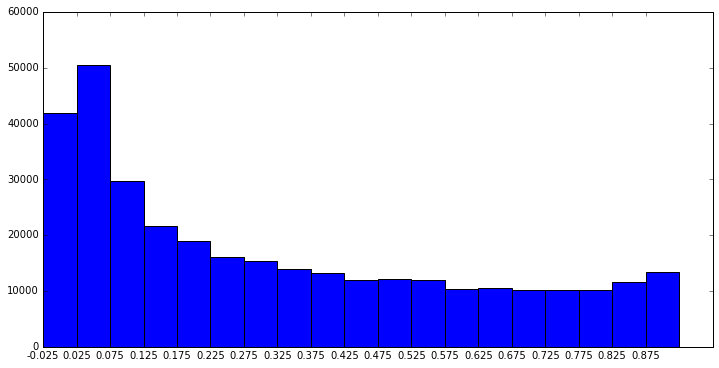

In [6]:
from datetime import datetime
start_time = datetime.now()
c=1
m=1
comp = np.reshape(y_pred,[-1, c + 2, m])
mu_pred = comp[:, :c, :]
sigma_pred = comp[:, c, :]
alpha_pred = comp[:, c + 1, :]
alpha_pred=alpha_pred.argmax(axis=1)
y_pred = np.array([mu_pred[i,:,alpha_pred[i]] for i in xrange(len(mu_pred))])


end_time = datetime.now()
print 
print "*********************************  Prediction ends  *********************************"
print
print('Duration: {}'.format(end_time - start_time))

from datetime import datetime
start_time = datetime.now()
import matplotlib.pyplot as plt
%matplotlib inline
tolerance = 1e-1
idx = np.where(np.abs(y_pred-y_val)>tolerance)[0]

print 'Elements below tolerance: ' + str(len(idx))

measure = np.mean(np.abs((y_pred-y_val*1.)))
print 'Mean Absolute Error:  ' + str(measure) 
measure = np.mean(np.power((y_pred-y_val*1.),2))
print 'Mean Squared Error:  ' + str(measure) 
measure = np.sqrt(measure)
print 'Root Mean Squared Error:  ' + str(measure) 
i = np.argmax(np.abs((y_pred-y_val*1.)))
measure = np.abs((y_pred[i]-y_val[i]*1.))
print 'Maximum Total Error:  ' + str(measure) + '(real: ' + str(y_val[i]) + ', predicted: ' + str(y_pred[i]) + ')'

measure = np.abs((y_pred[idx]-y_val[idx]))/(np.abs(y_val[idx])+1e-16)
MAE10 = np.where(measure>0.1)[0]
print 'AE 10% ' + str(1.*len(MAE10)/len(y_val)) + ' (' + str(len(MAE10)) + ')'

bins = np.arange(0,1.0,0.05)-0.025
measure = np.abs(y_pred[idx]-y_val[idx])/(np.abs(y_val[idx])+1e-16)
[dat, bins] = np.histogram(measure,bins=bins)
plt.bar(np.arange(len(dat)),dat,width =1)
plt.xticks(np.arange(len(dat)),bins[:-1])
plt.gcf().set_size_inches((10,6))

plt.gcf().set_size_inches((12,6))
 
end_time = datetime.now()
print 
print "*********************************  End  *********************************"
print
print('Duration: {}'.format(end_time - start_time))

In [ ]:
graph5 = graph
#Then we run first code again to define a new network in the pointer graph

In [12]:
#dummy code
graph.load_weights('MDN-weights.hdf5')

In [14]:
#y_pred = model.predict(X_val)['output']
from datetime import datetime
start_time = datetime.now()
y_pred = graph.predict(data={'input':X_val.squeeze()})['output']
end_time = datetime.now()
print 
print "*********************************  Prediction ends  *********************************"
print
print('Duration: {}'.format(end_time - start_time))


*********************************  Prediction ends  *********************************

Duration: 0:00:28.566352



*********************************  Prediction ends  *********************************

Duration: 0:00:02.241967
Elements below tolerance: 937641
Mean Absolute Error:  113.59279267
Mean Squared Error:  9055483.09071
Root Mean Squared Error:  3009.23297382
Maximum Total Error:  [ 1459237.66311133](real: [-1459236.], predicted: [ 1.66311133])
AE 10% 0.516293676637 (829068)

*********************************  End  *********************************

Duration: 0:00:00.423493


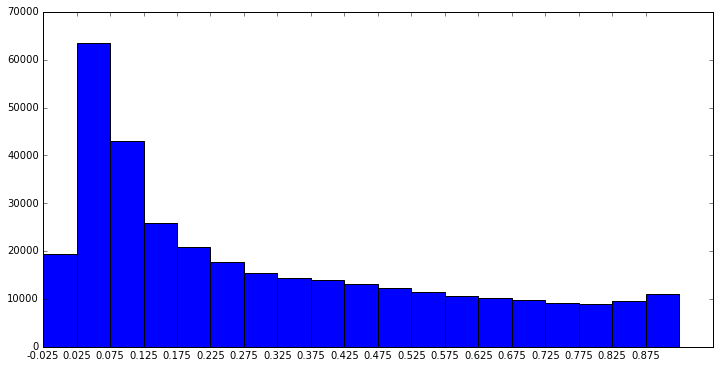

In [15]:
from datetime import datetime
start_time = datetime.now()
c=1
m=1
comp = np.reshape(y_pred,[-1, c + 2, m])
mu_pred = comp[:, :c, :]
sigma_pred = comp[:, c, :]
alpha_pred = comp[:, c + 1, :]
alpha_pred=alpha_pred.argmax(axis=1)
y_pred = np.array([mu_pred[i,:,alpha_pred[i]] for i in xrange(len(mu_pred))])


end_time = datetime.now()
print 
print "*********************************  Prediction ends  *********************************"
print
print('Duration: {}'.format(end_time - start_time))

from datetime import datetime
start_time = datetime.now()
import matplotlib.pyplot as plt
%matplotlib inline
tolerance = 1e-1
idx = np.where(np.abs(y_pred-y_val)>tolerance)[0]

print 'Elements below tolerance: ' + str(len(idx))

measure = np.mean(np.abs((y_pred-y_val*1.)))
print 'Mean Absolute Error:  ' + str(measure) 
measure = np.mean(np.power((y_pred-y_val*1.),2))
print 'Mean Squared Error:  ' + str(measure) 
measure = np.sqrt(measure)
print 'Root Mean Squared Error:  ' + str(measure) 
i = np.argmax(np.abs((y_pred-y_val*1.)))
measure = np.abs((y_pred[i]-y_val[i]*1.))
print 'Maximum Total Error:  ' + str(measure) + '(real: ' + str(y_val[i]) + ', predicted: ' + str(y_pred[i]) + ')'

measure = np.abs((y_pred[idx]-y_val[idx]))/(np.abs(y_val[idx])+1e-16)
MAE10 = np.where(measure>0.1)[0]
print 'AE 10% ' + str(1.*len(MAE10)/len(y_val)) + ' (' + str(len(MAE10)) + ')'

bins = np.arange(0,1.0,0.05)-0.025
measure = np.abs(y_pred[idx]-y_val[idx])/(np.abs(y_val[idx])+1e-16)
[dat, bins] = np.histogram(measure,bins=bins)
plt.bar(np.arange(len(dat)),dat,width =1)
plt.xticks(np.arange(len(dat)),bins[:-1])
plt.gcf().set_size_inches((10,6))

plt.gcf().set_size_inches((12,6))
 
end_time = datetime.now()
print 
print "*********************************  End  *********************************"
print
print('Duration: {}'.format(end_time - start_time))

In [13]:
graph3 = graph
#Then we run first code again to define a new network in the pointer graph

In [15]:
#dummy code
ograph.load_weights('MDN-weights.hdf5')

In [19]:
#y_pred = model.predict(X_val)['output']
from datetime import datetime
start_time = datetime.now()
y_pred = graph.predict(data={'input':X_val.squeeze()})['output']
end_time = datetime.now()
print 
print "*********************************  Prediction ends  *********************************"
print
print('Duration: {}'.format(end_time - start_time))


*********************************  Prediction ends  *********************************

Duration: 0:00:28.572542



*********************************  Prediction ends  *********************************

Duration: 0:00:02.251678
Elements below tolerance: 1132860
Mean Absolute Error:  113.582114423
Mean Squared Error:  9055460.97698
Root Mean Squared Error:  3009.2292995
Maximum Total Error:  [ 1459230.90421629](real: [-1459236.], predicted: [-5.09578371])
AE 10% 0.634987890824 (1019668)

*********************************  End  *********************************

Duration: 0:00:00.457987


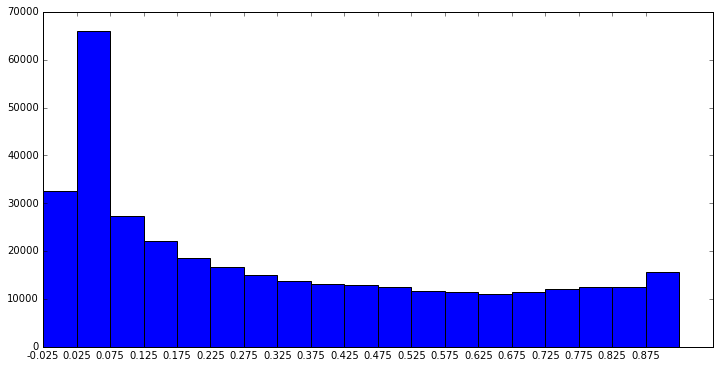

In [20]:
from datetime import datetime
start_time = datetime.now()
##y_predg2 = graphG2.predict(data={'input':X_val})['output']
c=1
m=1
comp = np.reshape(y_pred,[-1, c + 2, m])
mu_pred = comp[:, :c, :]
sigma_pred = comp[:, c, :]
alpha_pred = comp[:, c + 1, :]
alpha_pred=alpha_pred.argmax(axis=1)
y_pred = np.array([mu_pred[i,:,alpha_pred[i]] for i in xrange(len(mu_pred))])


end_time = datetime.now()
print 
print "*********************************  Prediction ends  *********************************"
print
print('Duration: {}'.format(end_time - start_time))
#y_pred = y_predg2

from datetime import datetime
start_time = datetime.now()
import matplotlib.pyplot as plt
%matplotlib inline
tolerance = 1e-1
idx = np.where(np.abs(y_pred-y_val)>tolerance)[0]

print 'Elements below tolerance: ' + str(len(idx))

measure = np.mean(np.abs((y_pred-y_val*1.)))
print 'Mean Absolute Error:  ' + str(measure) 
measure = np.mean(np.power((y_pred-y_val*1.),2))
print 'Mean Squared Error:  ' + str(measure) 
measure = np.sqrt(measure)
print 'Root Mean Squared Error:  ' + str(measure) 
i = np.argmax(np.abs((y_pred-y_val*1.)))
measure = np.abs((y_pred[i]-y_val[i]*1.))
print 'Maximum Total Error:  ' + str(measure) + '(real: ' + str(y_val[i]) + ', predicted: ' + str(y_pred[i]) + ')'

measure = np.abs((y_pred[idx]-y_val[idx]))/(np.abs(y_val[idx])+1e-16)
MAE10 = np.where(measure>0.1)[0]
print 'AE 10% ' + str(1.*len(MAE10)/len(y_val)) + ' (' + str(len(MAE10)) + ')'

bins = np.arange(0,1.0,0.05)-0.025
measure = np.abs(y_pred[idx]-y_val[idx])/(np.abs(y_val[idx])+1e-16)
[dat, bins] = np.histogram(measure,bins=bins)
plt.bar(np.arange(len(dat)),dat,width =1)
plt.xticks(np.arange(len(dat)),bins[:-1])
plt.gcf().set_size_inches((10,6))

plt.gcf().set_size_inches((12,6))
 
end_time = datetime.now()
print 
print "*********************************  End  *********************************"
print
print('Duration: {}'.format(end_time - start_time))

In [16]:
# Then we run the code again to define a new network in the pointer graph
graph4 = graph

In [18]:
#dummy code
ograph.load_weights('MDN-weights.hdf5')

In [24]:
#y_pred = model.predict(X_val)['output']
from datetime import datetime
start_time = datetime.now()
y_pred = graph.predict(data={'input':X_val.squeeze()})['output']
end_time = datetime.now()
print 
print "*********************************  Prediction ends  *********************************"
print
print('Duration: {}'.format(end_time - start_time))


*********************************  Prediction ends  *********************************

Duration: 0:00:28.483699



*********************************  Prediction ends  *********************************

Duration: 0:00:02.265670
Elements below tolerance: 1104229
Mean Absolute Error:  113.664511533
Mean Squared Error:  9055169.18958
Root Mean Squared Error:  3009.18081703
Maximum Total Error:  [ 1459230.80856466](real: [-1459236.], predicted: [-5.19143534])
AE 10% 0.615566503322 (988481)

*********************************  End  *********************************

Duration: 0:00:00.450793


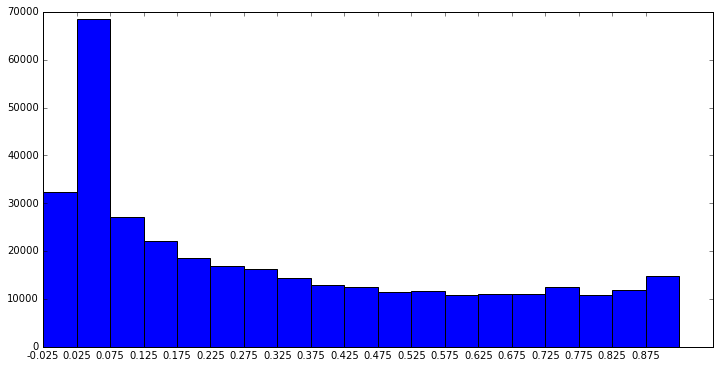

In [25]:
from datetime import datetime
start_time = datetime.now()
c=1
m=1
comp = np.reshape(y_pred,[-1, c + 2, m])
mu_pred = comp[:, :c, :]
sigma_pred = comp[:, c, :]
alpha_pred = comp[:, c + 1, :]
alpha_pred=alpha_pred.argmax(axis=1)
y_pred = np.array([mu_pred[i,:,alpha_pred[i]] for i in xrange(len(mu_pred))])

end_time = datetime.now()
print 
print "*********************************  Prediction ends  *********************************"
print
print('Duration: {}'.format(end_time - start_time))

from datetime import datetime
start_time = datetime.now()
import matplotlib.pyplot as plt
%matplotlib inline
tolerance = 1e-1
idx = np.where(np.abs(y_pred-y_val)>tolerance)[0]

print 'Elements below tolerance: ' + str(len(idx))

measure = np.mean(np.abs((y_pred-y_val*1.)))
print 'Mean Absolute Error:  ' + str(measure) 
measure = np.mean(np.power((y_pred-y_val*1.),2))
print 'Mean Squared Error:  ' + str(measure) 
measure = np.sqrt(measure)
print 'Root Mean Squared Error:  ' + str(measure) 
i = np.argmax(np.abs((y_pred-y_val*1.)))
measure = np.abs((y_pred[i]-y_val[i]*1.))
print 'Maximum Total Error:  ' + str(measure) + '(real: ' + str(y_val[i]) + ', predicted: ' + str(y_pred[i]) + ')'

measure = np.abs((y_pred[idx]-y_val[idx]))/(np.abs(y_val[idx])+1e-16)
MAE10 = np.where(measure>0.1)[0]
print 'AE 10% ' + str(1.*len(MAE10)/len(y_val)) + ' (' + str(len(MAE10)) + ')'

bins = np.arange(0,1.0,0.05)-0.025
measure = np.abs(y_pred[idx]-y_val[idx])/(np.abs(y_val[idx])+1e-16)
[dat, bins] = np.histogram(measure,bins=bins)
plt.bar(np.arange(len(dat)),dat,width =1)
plt.xticks(np.arange(len(dat)),bins[:-1])
plt.gcf().set_size_inches((10,6))

plt.gcf().set_size_inches((12,6))
 
end_time = datetime.now()
print 
print "*********************************  End  *********************************"
print
print('Duration: {}'.format(end_time - start_time))

In [19]:
#Then we run the code again to define a new network in the pointer graph
graph2 = graph

In [21]:
#dummy code
ograph.load_weights('MDN-weights.hdf5')

In [29]:
from datetime import datetime
start_time = datetime.now()
y_pred = graph.predict(data={'input':X_val.squeeze()})['output']
end_time = datetime.now()
print 
print "*********************************  Prediction ends  *********************************"
print
print('Duration: {}'.format(end_time - start_time))


*********************************  Prediction ends  *********************************

Duration: 0:00:28.605602



*********************************  Prediction ends  *********************************

Duration: 0:00:02.251155
Elements below tolerance: 848930
Mean Absolute Error:  113.738075762
Mean Squared Error:  9055774.1662
Root Mean Squared Error:  3009.28133716
Maximum Total Error:  [ 1459236.86362875](real: [-1459236.], predicted: [ 0.86362875])
AE 10% 0.464763200061 (746320)

*********************************  End  *********************************

Duration: 0:00:00.405319


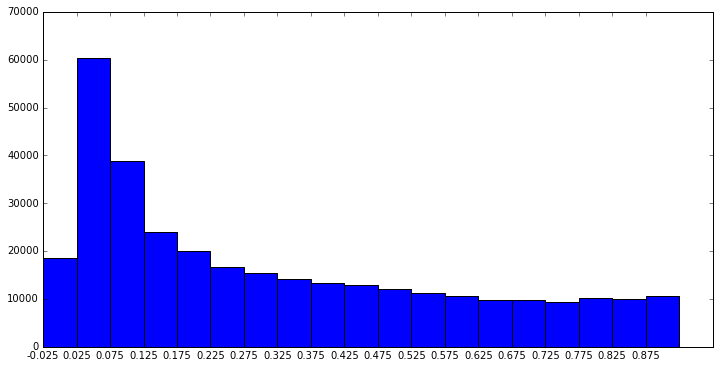

In [30]:
from datetime import datetime
start_time = datetime.now()
c=1
m=1
comp = np.reshape(y_pred,[-1, c + 2, m])
mu_pred = comp[:, :c, :]
sigma_pred = comp[:, c, :]
alpha_pred = comp[:, c + 1, :]
alpha_pred=alpha_pred.argmax(axis=1)
y_pred = np.array([mu_pred[i,:,alpha_pred[i]] for i in xrange(len(mu_pred))])


end_time = datetime.now()
print 
print "*********************************  Prediction ends  *********************************"
print
print('Duration: {}'.format(end_time - start_time))

from datetime import datetime
start_time = datetime.now()
import matplotlib.pyplot as plt
%matplotlib inline
tolerance = 1e-1
idx = np.where(np.abs(y_pred-y_val)>tolerance)[0]

print 'Elements below tolerance: ' + str(len(idx))

measure = np.mean(np.abs((y_pred-y_val*1.)))
print 'Mean Absolute Error:  ' + str(measure) 
measure = np.mean(np.power((y_pred-y_val*1.),2))
print 'Mean Squared Error:  ' + str(measure) 
measure = np.sqrt(measure)
print 'Root Mean Squared Error:  ' + str(measure) 
i = np.argmax(np.abs((y_pred-y_val*1.)))
measure = np.abs((y_pred[i]-y_val[i]*1.))
print 'Maximum Total Error:  ' + str(measure) + '(real: ' + str(y_val[i]) + ', predicted: ' + str(y_pred[i]) + ')'

measure = np.abs((y_pred[idx]-y_val[idx]))/(np.abs(y_val[idx])+1e-16)
MAE10 = np.where(measure>0.1)[0]
print 'AE 10% ' + str(1.*len(MAE10)/len(y_val)) + ' (' + str(len(MAE10)) + ')'

bins = np.arange(0,1.0,0.05)-0.025
measure = np.abs(y_pred[idx]-y_val[idx])/(np.abs(y_val[idx])+1e-16)
[dat, bins] = np.histogram(measure,bins=bins)
plt.bar(np.arange(len(dat)),dat,width =1)
plt.xticks(np.arange(len(dat)),bins[:-1])
plt.gcf().set_size_inches((10,6))

plt.gcf().set_size_inches((12,6))
 
end_time = datetime.now()
print 
print "*********************************  End  *********************************"
print
print('Duration: {}'.format(end_time - start_time))

In [22]:
graph1 = graph

# ENSEMBLE part

In [32]:
c=1
m=1
parameters = graph1.predict(data={'input':X_val.squeeze()})['output']

comp = np.reshape(parameters,[-1, c + 2, m])
mu_pred1 = comp[:, :c, :]
sigma_pred1 = comp[:, c, :]
alpha_pred1 = comp[:, c + 1, :]

parameters = graph2.predict(data={'input':X_val.squeeze()})['output']

comp = np.reshape(parameters,[-1, c + 2, m])
mu_pred2 = comp[:, :c, :]
sigma_pred2 = comp[:, c, :]
alpha_pred2 = comp[:, c + 1, :]

parameters = graph3.predict(data={'input':X_val.squeeze()})['output']

comp = np.reshape(parameters,[-1, c + 2, m])
mu_pred3 = comp[:, :c, :]
sigma_pred3 = comp[:, c, :]
alpha_pred3 = comp[:, c + 1, :]

parameters = graph4.predict(data={'input':X_val.squeeze()})['output']

comp = np.reshape(parameters,[-1, c + 2, m])
mu_pred4 = comp[:, :c, :]
sigma_pred4 = comp[:, c, :]
alpha_pred4 = comp[:, c + 1, :]

parameters = graph5.predict(data={'input':X_val.squeeze()})['output']

comp = np.reshape(parameters,[-1, c + 2, m])
mu_pred5 = comp[:, :c, :]
sigma_pred5 = comp[:, c, :]
alpha_pred5 = comp[:, c + 1, :]

In [33]:
mu_pred_s = (mu_pred1+mu_pred2+mu_pred3+mu_pred4+mu_pred5)/5.

sigma_pred_s = np.sqrt((((sigma_pred1**2+mu_pred1[...,0]**2)+\
(sigma_pred2**2+mu_pred2[...,0]**2)+\
(sigma_pred3**2+mu_pred3[...,0]**2)+\
(sigma_pred4**2+mu_pred4[...,0]**2)+\
(sigma_pred5**2+mu_pred5[...,0]**2))/5.)-mu_pred_s[...,0]**2)

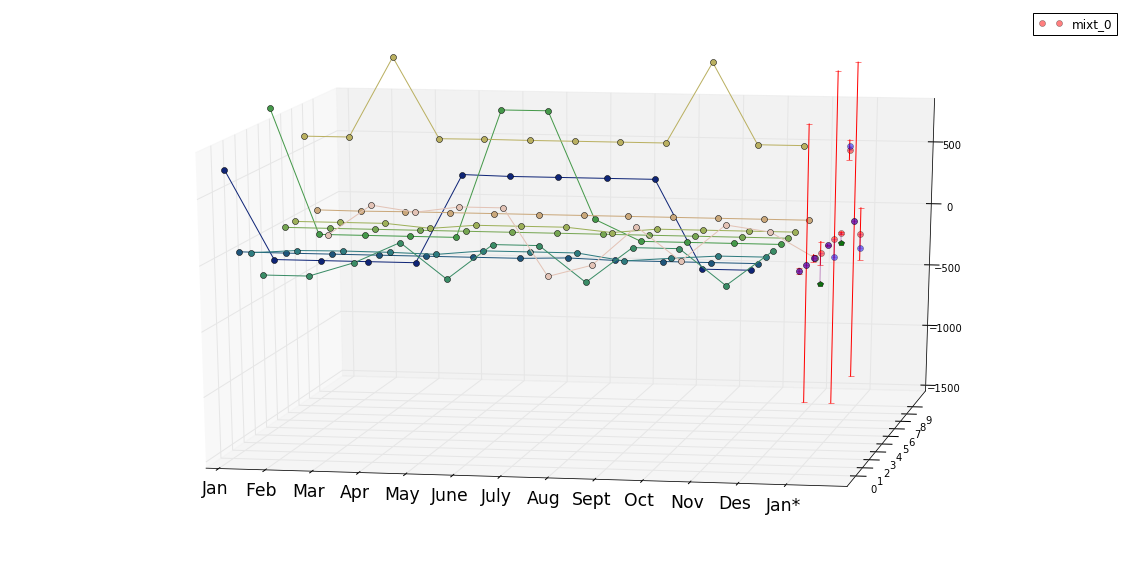

In [39]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
%matplotlib inline

import matplotlib.cm as cm

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

c=1
m=1

rang = 10
start = np.random.randint(0,y_val.shape[0]-rang)
v_rang = 1000

mu_pred = mu_pred_s[start:start+rang]
sigma_pred = sigma_pred_s[start:start+rang]
alpha_pred = alpha_pred5[start:start+rang]
y_pred = np.zeros((len(mu_pred)))

thr_alpha = 0.5

col = cm.autumn(np.linspace(0, 1, mu_pred.shape[-1]))

cont = []
cont_const = []
const = 100
guany_sig = []
erSigConst = np.zeros((2,rang))


color = cm.gist_earth(np.linspace(0, 1, rang+2))

for elem in xrange(rang):
    ax.plot(xs=np.arange(12),ys=[elem]*12,zs=X_val_orig[start+elem,:,0].reshape(-1), c=color[elem+1], marker='o')

zerror = 500
    
for mx in xrange(mu_pred.shape[-1]):
    for i in xrange(len(mu_pred)):
        if alpha_pred[i,mx] > thr_alpha:
            ax.plot([12, 12], [i, i], [mu_pred[i,0,mx]-np.sqrt(2)*sigma_pred[i,mx],
                                       mu_pred[i,0,mx]+np.sqrt(2)*sigma_pred[i,mx]], 
                    marker="_", c=col[mx], alpha=alpha_pred[i,mx])
            y_pred[i] = mu_pred[i,0,mx]
            #In order to avoid ERROR of 0.1 when approx 0, we add a margin of 0.1€
            if mu_pred[i,0,mx]+np.sqrt(2)*sigma_pred[i,mx]+0.1<y_val[start+i] or mu_pred[i,0,mx]-np.sqrt(2)*sigma_pred[i,mx]-0.1>y_val[start+i]:
                cont += [i]
                if mu_pred[i,0,mx]+const<y_val[start+i] or mu_pred[i,0,mx]-const>y_val[start+i]:
                    guany_sig += [const-np.sqrt(2)*sigma_pred[i,mx]-0.1]
                    cont_const += [i]
                else:
                    guany_sig += [np.sqrt(2)*sigma_pred[i,mx]+0.1-const]
            elif mu_pred[i,0,mx]+const<y_val[start+i] or mu_pred[i,0,mx]-const>y_val[start+i]:
                cont_const += [i]
                guany_sig += [const-np.sqrt(2)*sigma_pred[i,mx]-0.1]
            
            erSigConst[0,i] = np.sqrt(2)*sigma_pred[i,mx]+0.1 - np.abs(mu_pred[i,0,mx]-y_val[start+i])
            erSigConst[1,i] = const - np.abs(mu_pred[i,0,mx]-y_val[start+i])
    
    tmp = alpha_pred[:,mx]>thr_alpha
    if np.sum(tmp) > 0:
        ax.plot([12]*rang,np.arange(rang)[tmp],
                    y_pred[tmp], color=col[mx],
                    linewidth=1, marker='o', linestyle=' ',
                    alpha=0.5, label='mixt_'+str(mx))
    else:
        print "Distribution",mx," has always alpha below",thr_alpha
        
for point in xrange(rang):
    if point in cont:
        ax.plot(xs=12, ys=point,zs=y_val[start+point], 
                color='green', linewidth=1, marker='p', 
                linestyle=' ',alpha=1)
    else:
        ax.plot(xs=12, ys=point,zs=y_val[start+point], 
                color='blue', linewidth=1, marker='o', 
                linestyle=' ',alpha=0.5)
    ax.plot(xs=[12, 12], ys=[point, point],zs=[y_val[start+point],y_pred[point]],
            marker="_", alpha = 0.4, color = 'purple')


ax.xaxis.set_ticks(range(13))
ax.xaxis.set_ticklabels(['Jan','Feb','Mar','Apr',
                    'May','June','July','Aug',
                    'Sept','Oct','Nov','Des','Jan*'])
ax.xaxis.set_tick_params(labelsize='xx-large')
ax.yaxis.set_ticks(range(rang))

ax.set_xlim3d(0, 13)
ax.set_ylim3d(-1, rang+1)
ax.set_zlim3d(-1500, 800)
ax.view_init(15, -80)

plt.gcf().set_size_inches((20,10))
plt.legend()
plt.show()


*********************************  Prediction ends  *********************************

Duration: 0:00:02.279990
Elements below tolerance: 954089
Mean Absolute Error:  113.220028349
Mean Squared Error:  9055350.57789
Root Mean Squared Error:  3009.21095603
Maximum Total Error:  [ 1459234.7805264](real: [-1459236.], predicted: [-1.2194736])
AE 10% 0.524820853315 (842761)

*********************************  End  *********************************

Duration: 0:00:00.425601


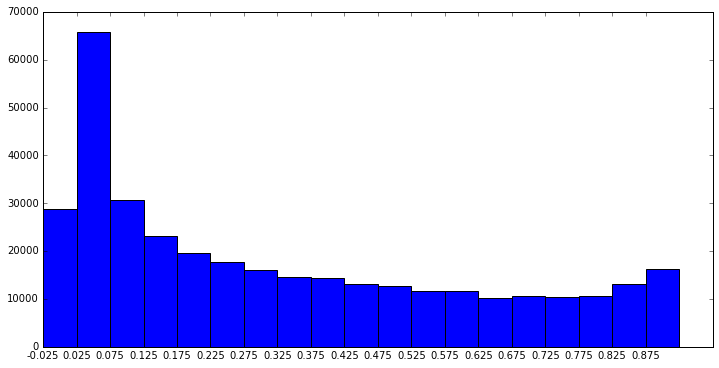

In [42]:
from datetime import datetime
start_time = datetime.now()
c=1
m=1

mu_pred = mu_pred_s
sigma_pred = sigma_pred_s
alpha_pred = alpha_pred5
alpha_pred=alpha_pred.argmax(axis=1)
y_pred = np.array([mu_pred[i,:,alpha_pred[i]] for i in xrange(len(mu_pred))])

end_time = datetime.now()
print 
print "*********************************  Prediction ends  *********************************"
print
print('Duration: {}'.format(end_time - start_time))

from datetime import datetime
start_time = datetime.now()
import matplotlib.pyplot as plt
%matplotlib inline
tolerance = 1e-1
idx = np.where(np.abs(y_pred-y_val)>tolerance)[0]

print 'Elements below tolerance: ' + str(len(idx))

measure = np.mean(np.abs((y_pred-y_val*1.)))
print 'Mean Absolute Error:  ' + str(measure) 
measure = np.mean(np.power((y_pred-y_val*1.),2))
print 'Mean Squared Error:  ' + str(measure) 
measure = np.sqrt(measure)
print 'Root Mean Squared Error:  ' + str(measure) 
i = np.argmax(np.abs((y_pred-y_val*1.)))
measure = np.abs((y_pred[i]-y_val[i]*1.))
print 'Maximum Total Error:  ' + str(measure) + '(real: ' + str(y_val[i]) + ', predicted: ' + str(y_pred[i]) + ')'

measure = np.abs((y_pred[idx]-y_val[idx]))/(np.abs(y_val[idx])+1e-16)
MAE10 = np.where(measure>0.1)[0]
print 'AE 10% ' + str(1.*len(MAE10)/len(y_val)) + ' (' + str(len(MAE10)) + ')'

bins = np.arange(0,1.0,0.05)-0.025
measure = np.abs(y_pred[idx]-y_val[idx])/(np.abs(y_val[idx])+1e-16)
[dat, bins] = np.histogram(measure,bins=bins)
plt.bar(np.arange(len(dat)),dat,width =1)
plt.xticks(np.arange(len(dat)),bins[:-1])
plt.gcf().set_size_inches((10,6))

plt.gcf().set_size_inches((12,6))
 
end_time = datetime.now()
print 
print "*********************************  End  *********************************"
print
print('Duration: {}'.format(end_time - start_time))

## Adversarial Data set part

In [5]:
sess2 = K.get_session()

In [6]:
from tqdm import tqdm
adv_X_val = X_val.squeeze().copy()
adv_steps = 100

#ADVERSARIAL VALUES FOR EACH ADVERSARIAL STEP
adv_serie_X_val = np.zeros((adv_steps,)+adv_X_val.shape)

bs = 229401 #selected value for convenience

#We store the parameters because is more efficient due to we need
# to calculate them to calculate the adversarial points.
#PARAMETERS OF THE MIXTURE FOR EACH ADVERSARIAL STEP
#Mixture output: (c+2)*m
#adv_step last is not computed
adv_serie_param = np.zeros((adv_steps-1,len(X_val),(c+2)*m))

adv_serie_X_val[0] = adv_X_val.copy()

for step in tqdm(xrange(1,adv_steps)):
    
    for i in xrange(0,len(X_val)-1,bs):

        adv_batch,adv_parameters = sess2.run(
            [graphADV.input + 0.08 * K.sign(K.gradients(
                        mean_log_LaPlace_like(graph.targets[0],
                                              graph.get_output_at(-1)),
                        graph.input)),
             graph.get_output_at(-1)],
            feed_dict={graphADV.input:adv_X_val[i:i+bs],
                       graph.targets[0]:y_val[i:i+bs],
                       K.learning_phase(): 1})
        
        adv_X_val[i:i+bs] = adv_batch.copy()
        adv_serie_param[step,i:i+bs] = adv_parameters.copy()
        
    #log process
    print np.reshape(adv_serie_param[step],[-1, c + 2, m])[:, c, :].sum()    
    adv_serie_X_val[step] = adv_X_val.copy()

  0%|          | 0/99 [00:00<?, ?it/s]

235315852.673


  1%|          | 1/99 [00:15<24:32, 15.02s/it]

217677677.552


  2%|▏         | 2/99 [00:30<24:40, 15.26s/it]

142537600.724


  3%|▎         | 3/99 [00:47<25:02, 15.65s/it]

239446455.407


  4%|▍         | 4/99 [01:05<26:00, 16.43s/it]

164172227.191


  5%|▌         | 5/99 [01:24<27:02, 17.26s/it]

232587656.013


  6%|▌         | 6/99 [01:45<28:08, 18.15s/it]

187783616.284


  7%|▋         | 7/99 [02:06<29:25, 19.19s/it]

237958712.554


  8%|▊         | 8/99 [02:28<30:16, 19.97s/it]

210752750.379


  9%|▉         | 9/99 [02:52<31:58, 21.31s/it]

249393991.422


 10%|█         | 10/99 [03:18<33:42, 22.73s/it]

231436066.868


 11%|█         | 11/99 [03:44<34:42, 23.66s/it]

263817102.065


 12%|█▏        | 12/99 [04:12<36:06, 24.90s/it]

250822308.034


 13%|█▎        | 13/99 [04:40<36:47, 25.66s/it]

280466568.564


 14%|█▍        | 14/99 [05:08<37:37, 26.56s/it]

268176795.245


 15%|█▌        | 15/99 [05:40<39:13, 28.02s/it]

295612830.605


 16%|█▌        | 16/99 [06:11<40:20, 29.16s/it]

284905773.308


 17%|█▋        | 17/99 [06:46<41:58, 30.71s/it]

311468652.734


 18%|█▊        | 18/99 [07:21<43:14, 32.03s/it]

300142990.049


 19%|█▉        | 19/99 [07:58<44:54, 33.68s/it]

326043287.802


 20%|██        | 20/99 [08:36<46:02, 34.97s/it]

314674892.4


 21%|██        | 21/99 [09:19<48:22, 37.21s/it]

339647013.104


 22%|██▏       | 22/99 [09:58<48:40, 37.93s/it]

328837692.888


 23%|██▎       | 23/99 [10:39<49:08, 38.79s/it]

352912446.388


 24%|██▍       | 24/99 [11:24<50:36, 40.48s/it]

342379290.562


 25%|██▌       | 25/99 [12:06<50:43, 41.13s/it]

365970425.916


 26%|██▋       | 26/99 [12:51<51:16, 42.14s/it]

355487426.766


 27%|██▋       | 27/99 [13:37<51:59, 43.32s/it]

378378121.681


 28%|██▊       | 28/99 [14:23<52:22, 44.26s/it]

368228191.227


 29%|██▉       | 29/99 [15:17<55:00, 47.14s/it]

391475948.46


 30%|███       | 30/99 [16:06<54:49, 47.68s/it]

380738296.363


 31%|███▏      | 31/99 [16:56<54:51, 48.40s/it]

403115759.991


 32%|███▏      | 32/99 [17:49<55:24, 49.62s/it]

393276179.493


 33%|███▎      | 33/99 [18:42<55:43, 50.66s/it]

415238462.976


 34%|███▍      | 34/99 [19:42<58:06, 53.64s/it]

405388175.935


 35%|███▌      | 35/99 [20:38<57:59, 54.37s/it]

427497499.322


 36%|███▋      | 36/99 [21:36<58:02, 55.29s/it]

417519757.982


 37%|███▋      | 37/99 [22:35<58:11, 56.32s/it]

439365545.286


 38%|███▊      | 38/99 [23:34<58:12, 57.25s/it]

429843144.986


 39%|███▉      | 39/99 [24:35<58:20, 58.35s/it]

451433420.106


 40%|████      | 40/99 [26:10<1:08:04, 69.23s/it]

441864418.308


 41%|████▏     | 41/99 [27:13<1:05:16, 67.53s/it]

463434646.882


 42%|████▏     | 42/99 [28:17<1:03:10, 66.49s/it]

453752341.475


 43%|████▎     | 43/99 [29:23<1:01:49, 66.25s/it]

475233928.783


 44%|████▍     | 44/99 [30:30<1:00:54, 66.45s/it]

465711514.961


 45%|████▌     | 45/99 [31:38<1:00:18, 67.01s/it]

486636105.551


 46%|████▋     | 46/99 [32:48<59:52, 67.78s/it]  

477548067.756


 47%|████▋     | 47/99 [34:14<1:03:30, 73.28s/it]

498535632.79


 48%|████▊     | 48/99 [35:26<1:02:01, 72.97s/it]

489442020.321


 49%|████▉     | 49/99 [36:39<1:00:52, 73.06s/it]

510209914.058


 51%|█████     | 50/99 [37:54<1:00:10, 73.68s/it]

501240290.32


 52%|█████▏    | 51/99 [39:13<1:00:03, 75.06s/it]

521966392.726


 53%|█████▎    | 52/99 [40:30<59:19, 75.73s/it]  

512870411.467


 54%|█████▎    | 53/99 [41:48<58:40, 76.54s/it]

532638269.811


 55%|█████▍    | 54/99 [43:09<58:13, 77.64s/it]

524626860.092


 56%|█████▌    | 55/99 [44:30<57:43, 78.71s/it]

545455264.799


 57%|█████▋    | 56/99 [46:41<1:07:39, 94.42s/it]

536787675.97


 58%|█████▊    | 57/99 [48:05<1:03:49, 91.19s/it]

557230313.342


 59%|█████▊    | 58/99 [49:30<1:01:02, 89.32s/it]

548183858.8


 60%|█████▉    | 59/99 [50:56<58:56, 88.41s/it]  

568197602.113


 61%|██████    | 60/99 [52:23<57:19, 88.18s/it]

559864689.022


 62%|██████▏   | 61/99 [53:53<56:02, 88.48s/it]

579948665.319


 63%|██████▎   | 62/99 [55:23<54:52, 88.99s/it]

571794561.437


 64%|██████▎   | 63/99 [56:54<53:51, 89.75s/it]

591442395.685


 65%|██████▍   | 64/99 [58:27<52:54, 90.70s/it]

583334562.533


 66%|██████▌   | 65/99 [1:00:02<52:00, 91.78s/it]

602731820.525


 67%|██████▋   | 66/99 [1:02:47<1:02:36, 113.84s/it]

595364426.918


 68%|██████▊   | 67/99 [1:04:30<59:04, 110.76s/it]  

614562514.264


 69%|██████▊   | 68/99 [1:06:08<55:14, 106.92s/it]

606936949.997


 70%|██████▉   | 69/99 [1:07:48<52:18, 104.61s/it]

626143670.039


 71%|███████   | 70/99 [1:09:28<50:00, 103.47s/it]

618455113.418


 72%|███████▏  | 71/99 [1:11:21<49:32, 106.17s/it]

637516959.213


 73%|███████▎  | 72/99 [1:13:14<48:41, 108.19s/it]

630039639.86


 74%|███████▎  | 73/99 [1:15:08<47:40, 110.03s/it]

650077669.536


 75%|███████▍  | 74/99 [1:17:03<46:28, 111.52s/it]

641706173.988


MemoryError: 

### If it is impossible to allocate all the input adversarial history points, forget them.

In [6]:
from tqdm import tqdm
adv_X_val = X_val.squeeze().copy()
adv_steps = 100

bs = 229401 #selected value for convenience

#We store the parameters because is more efficient due to we need
# to calculate them to calculate the adversarial points.
#PARAMETERS OF THE MIXTURE FOR EACH ADVERSARIAL STEP
#Mixture output: (c+2)*m
#adv_step last is not computed
adv_serie_param = np.zeros((adv_steps-1,len(X_val),(c+2)*m))

for step in tqdm(xrange(1,adv_steps)):
    
    for i in xrange(0,len(X_val)-1,bs):

        adv_batch,adv_parameters = sess2.run(
            [graphADV.input + 0.08 * K.sign(K.gradients(
                        mean_log_LaPlace_like(graph.targets[0],
                                              graph.get_output_at(-1)),
                        graph.input)),
             graph.get_output_at(-1)],
            feed_dict={graphADV.input:adv_X_val[i:i+bs],
                       graph.targets[0]:y_val[i:i+bs],
                       K.learning_phase(): 1})
        
        adv_X_val[i:i+bs] = adv_batch.copy()
        adv_serie_param[step,i:i+bs] = adv_parameters.copy()
        
    #log process
    print np.reshape(adv_serie_param[step],[-1, c + 2, m])[:, c, :].sum()    

  0%|          | 0/99 [00:00<?, ?it/s]

235110325.731


  1%|          | 1/99 [00:14<23:45, 14.55s/it]

217573384.329


  2%|▏         | 2/99 [00:29<23:54, 14.79s/it]

141999206.34


  3%|▎         | 3/99 [00:45<24:13, 15.14s/it]

239904009.488


  4%|▍         | 4/99 [01:03<25:07, 15.87s/it]

163761937.718


  5%|▌         | 5/99 [01:21<26:01, 16.62s/it]

233181387.817


  6%|▌         | 6/99 [01:41<27:08, 17.51s/it]

187582237.234


  7%|▋         | 7/99 [02:02<28:22, 18.51s/it]

237270643.725


  8%|▊         | 8/99 [02:23<29:15, 19.30s/it]

210776508.956


  9%|▉         | 9/99 [02:46<30:38, 20.43s/it]

249277511.909


 10%|█         | 10/99 [03:10<32:04, 21.63s/it]

231413880.526


 11%|█         | 11/99 [03:35<32:59, 22.49s/it]

264050358.204


 12%|█▏        | 12/99 [04:02<34:29, 23.79s/it]

250655132.701


 13%|█▎        | 13/99 [04:28<35:21, 24.67s/it]

280058210.106


 14%|█▍        | 14/99 [04:56<36:20, 25.65s/it]

268607358.753


 15%|█▌        | 15/99 [05:27<37:55, 27.09s/it]

295489856.441


 16%|█▌        | 16/99 [05:57<38:42, 27.99s/it]

284658132.678


 17%|█▋        | 17/99 [06:30<40:19, 29.51s/it]

310446048.555


 18%|█▊        | 18/99 [07:02<41:03, 30.41s/it]

299819379.947


 19%|█▉        | 19/99 [07:36<41:50, 31.39s/it]

324715850.728


 20%|██        | 20/99 [08:11<42:39, 32.40s/it]

314798869.66


 21%|██        | 21/99 [08:49<44:17, 34.07s/it]

339385100.372


 22%|██▏       | 22/99 [09:26<44:51, 34.96s/it]

328632909.488


 23%|██▎       | 23/99 [10:04<45:28, 35.90s/it]

353269028.269


 24%|██▍       | 24/99 [10:46<47:03, 37.65s/it]

342268112.569


 25%|██▌       | 25/99 [11:26<47:27, 38.49s/it]

366294914.242


 26%|██▋       | 26/99 [12:08<47:58, 39.43s/it]

355246651.507


 27%|██▋       | 27/99 [12:51<48:32, 40.45s/it]

378391963.138


 28%|██▊       | 28/99 [13:34<49:03, 41.46s/it]

368008739.122


 29%|██▉       | 29/99 [14:22<50:33, 43.34s/it]

391078570.414


 30%|███       | 30/99 [15:08<50:46, 44.15s/it]

380851575.31


 31%|███▏      | 31/99 [15:55<51:03, 45.05s/it]

403442142.369


 32%|███▏      | 32/99 [16:44<51:22, 46.01s/it]

393147776.925


 33%|███▎      | 33/99 [17:33<51:44, 47.03s/it]

415692043.071


 34%|███▍      | 34/99 [18:27<53:06, 49.02s/it]

405284301.695


 35%|███▌      | 35/99 [19:18<53:07, 49.81s/it]

427873170.259


 36%|███▋      | 36/99 [20:11<53:15, 50.72s/it]

417623015.5


 37%|███▋      | 37/99 [21:05<53:27, 51.74s/it]

439144234.93


 38%|███▊      | 38/99 [22:00<53:39, 52.78s/it]

429293225.874


 39%|███▉      | 39/99 [22:57<53:50, 53.84s/it]

451254373.405


 40%|████      | 40/99 [23:58<55:10, 56.11s/it]

441719469.912


 41%|████▏     | 41/99 [24:57<54:59, 56.90s/it]

462848688.462


 42%|████▏     | 42/99 [25:57<54:55, 57.82s/it]

453736993.668


 43%|████▎     | 43/99 [26:58<54:56, 58.86s/it]

474937536.755


 44%|████▍     | 44/99 [28:01<54:56, 59.94s/it]

465273255.764


 45%|████▌     | 45/99 [29:04<54:59, 61.10s/it]

486285219.816


 46%|████▋     | 46/99 [30:10<55:01, 62.29s/it]

477512560.185


 47%|████▋     | 47/99 [31:16<55:03, 63.52s/it]

498524088.13


 48%|████▊     | 48/99 [32:28<56:13, 66.15s/it]

488946929.728


 49%|████▉     | 49/99 [33:37<55:49, 66.99s/it]

509954589.425


 51%|█████     | 50/99 [34:47<55:29, 67.94s/it]

500951800.087


 52%|█████▏    | 51/99 [35:59<55:13, 69.02s/it]

521064586.672


 53%|█████▎    | 52/99 [37:11<54:53, 70.08s/it]

512524309.07


 54%|█████▎    | 53/99 [38:25<54:34, 71.18s/it]

533018106.748


 55%|█████▍    | 54/99 [39:40<54:16, 72.37s/it]

524568229.046


 56%|█████▌    | 55/99 [40:56<53:54, 73.52s/it]

544299759.451


 57%|█████▋    | 56/99 [42:19<54:42, 76.33s/it]

536313324.714


 58%|█████▊    | 57/99 [43:38<53:56, 77.05s/it]

555891460.698


 59%|█████▊    | 58/99 [44:58<53:16, 77.96s/it]

548237646.772


 60%|█████▉    | 59/99 [46:19<52:33, 78.84s/it]

568222443.118


 61%|██████    | 60/99 [47:41<51:56, 79.91s/it]

559484366.916


 62%|██████▏   | 61/99 [49:05<51:16, 80.96s/it]

579385742.739


 63%|██████▎   | 62/99 [50:29<50:34, 82.02s/it]

571248396.746


 64%|██████▎   | 63/99 [51:55<49:52, 83.12s/it]

591143985.932


 65%|██████▍   | 64/99 [53:22<49:07, 84.22s/it]

582916935.587


 66%|██████▌   | 65/99 [54:50<48:20, 85.31s/it]

602919002.529


 67%|██████▋   | 66/99 [56:26<48:40, 88.50s/it]

594416238.619


 68%|██████▊   | 67/99 [57:56<47:30, 89.08s/it]

614519825.338


 69%|██████▊   | 68/99 [59:28<46:25, 89.87s/it]

606171501.572


 70%|██████▉   | 69/99 [1:01:01<45:24, 90.82s/it]

625042738.335


 71%|███████   | 70/99 [1:02:35<44:24, 91.88s/it]

617437497.942


 72%|███████▏  | 71/99 [1:04:11<43:21, 92.91s/it]

637352608.421


 73%|███████▎  | 72/99 [1:05:48<42:24, 94.25s/it]

629313900.239


 74%|███████▎  | 73/99 [1:07:27<41:27, 95.69s/it]

649368305.923


 75%|███████▍  | 74/99 [1:09:07<40:26, 97.08s/it]

641264342.076


 76%|███████▌  | 75/99 [1:10:49<39:21, 98.40s/it]

660617585.992


 77%|███████▋  | 76/99 [1:12:32<38:14, 99.76s/it]

653122243.626


 78%|███████▊  | 77/99 [1:14:16<37:05, 101.17s/it]

671625186.405


 79%|███████▉  | 78/99 [1:17:00<41:59, 119.98s/it]

663802551.506


 80%|███████▉  | 79/99 [1:23:45<1:08:29, 205.47s/it]

683294332.259


 81%|████████  | 80/99 [1:25:52<57:38, 182.02s/it]  

675767000.149


 82%|████████▏ | 81/99 [1:27:43<48:09, 160.53s/it]

694561354.178


 83%|████████▎ | 82/99 [1:29:34<41:17, 145.74s/it]

687463646.224


 84%|████████▍ | 83/99 [1:36:51<1:02:09, 233.07s/it]

706414911.182


 85%|████████▍ | 84/99 [1:38:45<49:23, 197.58s/it]  

699237264.893


 86%|████████▌ | 85/99 [1:40:40<40:18, 172.79s/it]

717056494.606


 87%|████████▋ | 86/99 [1:42:36<33:43, 155.64s/it]

710138397.031


 88%|████████▊ | 87/99 [1:44:33<28:48, 144.07s/it]

728164538.856


 89%|████████▉ | 88/99 [1:46:34<25:09, 137.25s/it]

722248222.266


 90%|████████▉ | 89/99 [1:48:35<22:03, 132.36s/it]

740720009.057


 91%|█████████ | 90/99 [1:50:40<19:31, 130.13s/it]

734168983.211


 92%|█████████▏| 91/99 [1:53:49<19:42, 147.79s/it]

751791092.34


 93%|█████████▎| 92/99 [2:06:19<38:18, 328.42s/it]

745151502.611


 94%|█████████▍| 93/99 [2:13:05<35:10, 351.71s/it]

763200438.892


 95%|█████████▍| 94/99 [2:15:15<23:45, 285.15s/it]

756468245.858


 96%|█████████▌| 95/99 [2:17:25<15:53, 238.43s/it]

774076562.282


 97%|█████████▋| 96/99 [2:19:36<10:19, 206.34s/it]

768410149.044


 98%|█████████▊| 97/99 [2:21:49<06:08, 184.27s/it]

785804237.412


 99%|█████████▉| 98/99 [2:24:02<02:49, 169.08s/it]


IndexError: index 99 is out of bounds for axis 0 with size 99

### Random results obtained

[]

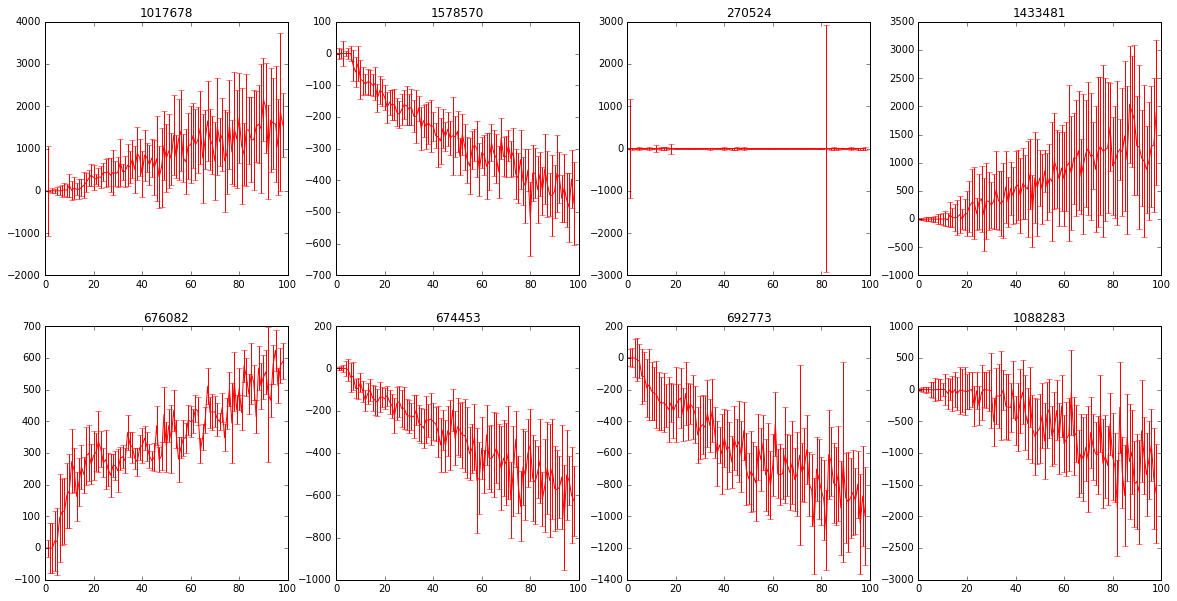

In [44]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as pyplot

sel = np.random.randint(0,len(X_val),size=8)

pyplot.figure(1)

for i in xrange(len(sel)):
    comp = np.reshape(adv_serie_param[:,sel[i]],[-1, c + 2, m])
    adv_mu_pred = comp[:, :c, :]
    adv_sigma_pred = comp[:, c, :]
    adv_alpha_pred = comp[:, c + 1, :]
    
    ax = pyplot.subplot(2,len(sel)/2,i+1)
    ax.errorbar(np.arange(len(adv_mu_pred)),
                adv_mu_pred.squeeze(),
                yerr=adv_sigma_pred.squeeze(),color='r')
    ax.set_title(str(sel[i]))

pyplot.gcf().set_size_inches((20,10))
pyplot.plot()

[]

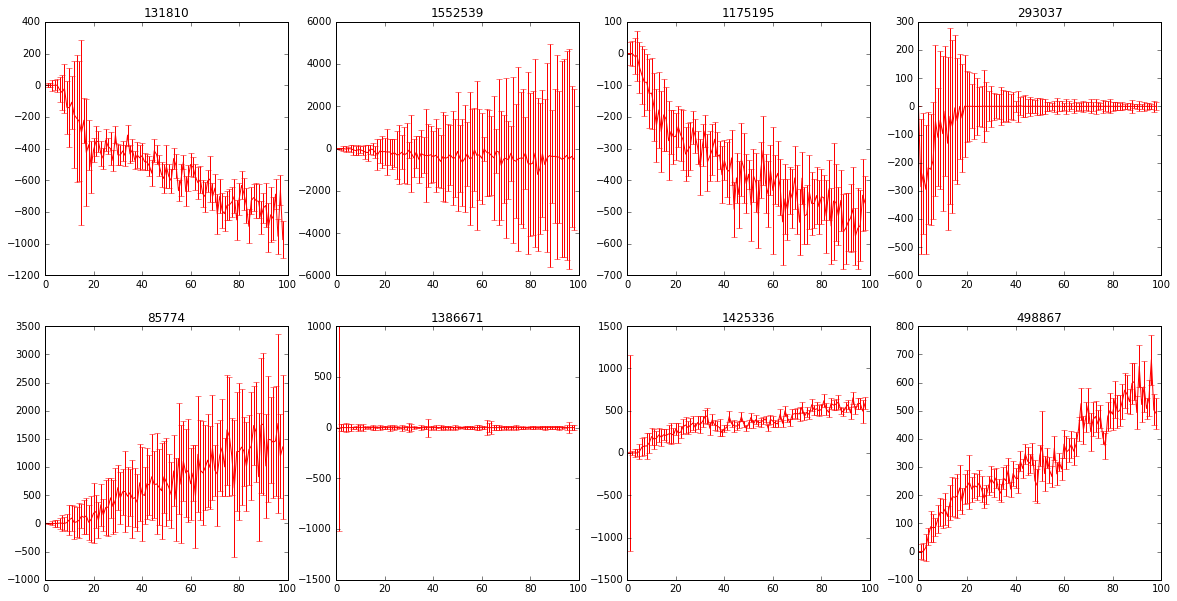

In [43]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as pyplot

sel = np.random.randint(0,len(X_val),size=8)

pyplot.figure(1)

for i in xrange(len(sel)):
    comp = np.reshape(adv_serie_param[:,sel[i]],[-1, c + 2, m])
    adv_mu_pred = comp[:, :c, :]
    adv_sigma_pred = comp[:, c, :]
    adv_alpha_pred = comp[:, c + 1, :]
    
    ax = pyplot.subplot(2,len(sel)/2,i+1)
    ax.errorbar(np.arange(len(adv_mu_pred)),
                adv_mu_pred.squeeze(),
                yerr=adv_sigma_pred.squeeze(),color='r')
    ax.set_title(str(sel[i]))

pyplot.gcf().set_size_inches((20,10))
pyplot.plot()

[]

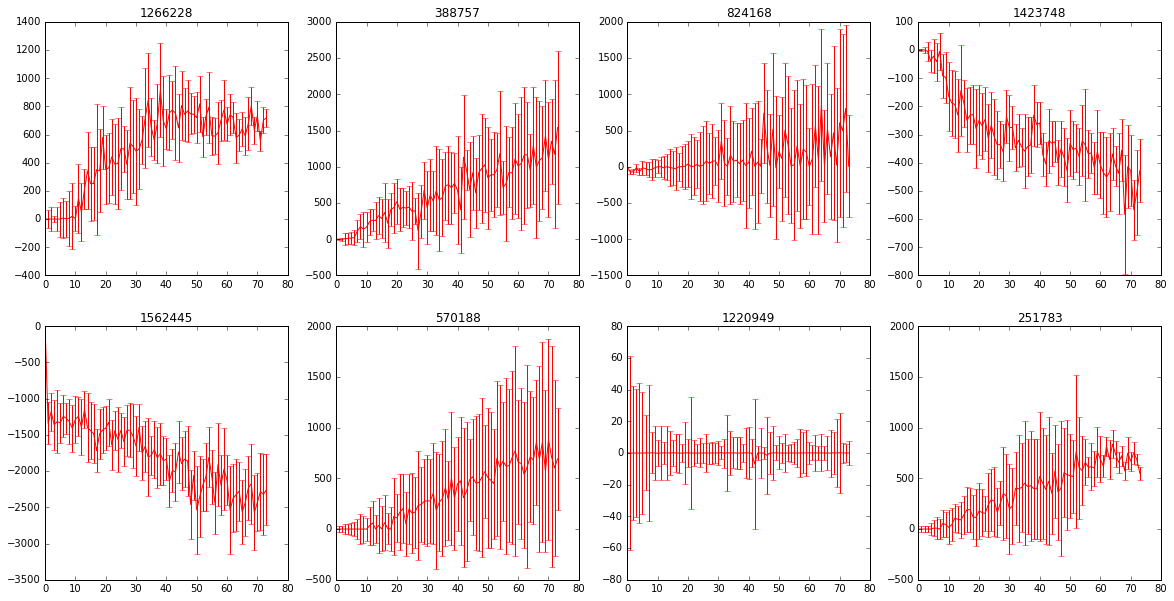

In [19]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as pyplot

sel = np.random.randint(0,len(X_val),size=8)

pyplot.figure(1)

for i in xrange(len(sel)):
    comp = np.reshape(adv_serie_param[:,sel[i]],[-1, c + 2, m])
    adv_mu_pred = comp[:, :c, :]
    adv_sigma_pred = comp[:, c, :]
    adv_alpha_pred = comp[:, c + 1, :]
    
    ax = pyplot.subplot(2,len(sel)/2,i+1)
    ax.errorbar(np.arange(len(adv_mu_pred)),
                adv_mu_pred.squeeze(),
                yerr=adv_sigma_pred.squeeze(),color='r')
    ax.set_title(str(sel[i]))

pyplot.gcf().set_size_inches((20,10))
pyplot.plot()

[]

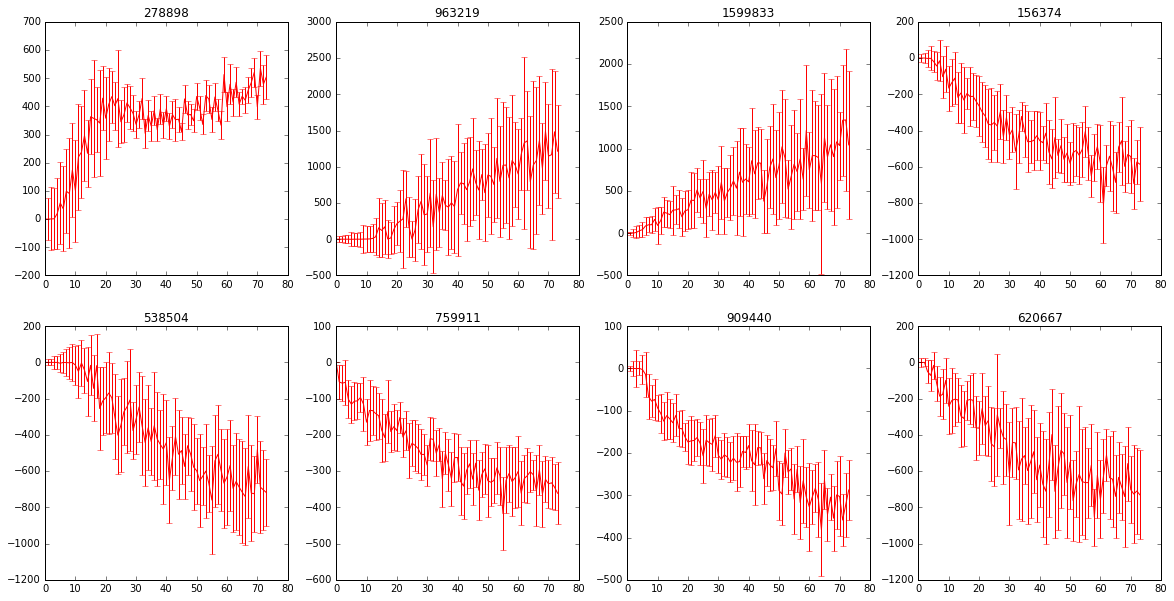

In [20]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as pyplot

sel = np.random.randint(0,len(X_val),size=8)

pyplot.figure(1)

for i in xrange(len(sel)):
    comp = np.reshape(adv_serie_param[:74,sel[i]],[-1, c + 2, m])
    adv_mu_pred = comp[:, :c, :]
    adv_sigma_pred = comp[:, c, :]
    adv_alpha_pred = comp[:, c + 1, :]
    
    ax = pyplot.subplot(2,len(sel)/2,i+1)
    ax.errorbar(np.arange(len(adv_mu_pred)),
                adv_mu_pred.squeeze(),
                yerr=adv_sigma_pred.squeeze(),color='r')
    ax.set_title(str(sel[i]))

pyplot.gcf().set_size_inches((20,10))
pyplot.plot()

[]

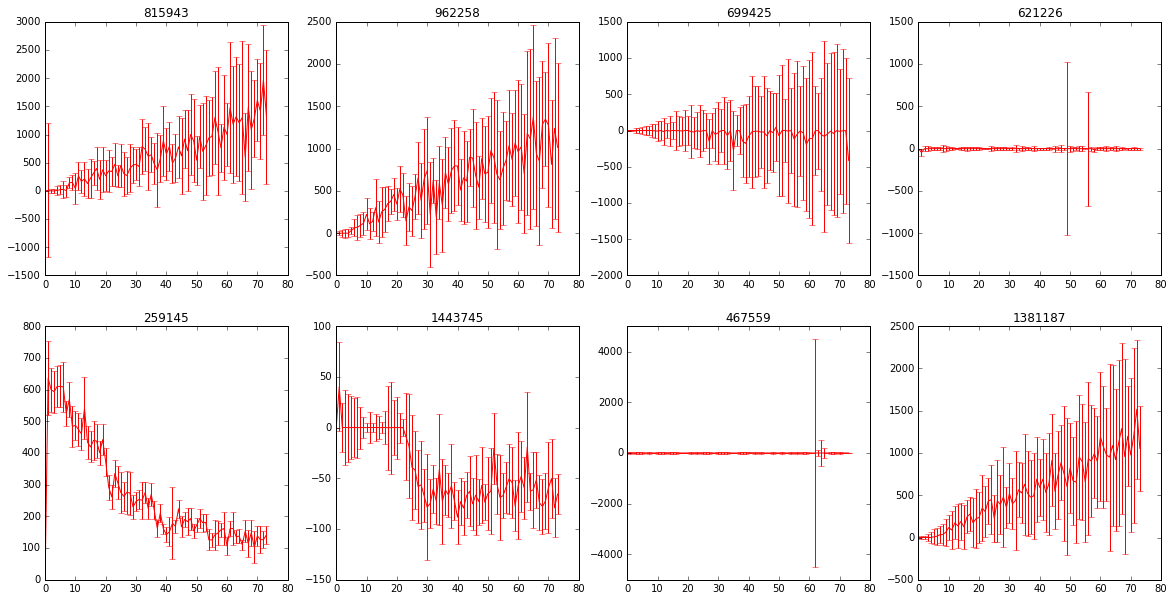

In [21]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as pyplot

sel = np.random.randint(0,len(X_val),size=8)

pyplot.figure(1)

for i in xrange(len(sel)):
    comp = np.reshape(adv_serie_param[:74,sel[i]],[-1, c + 2, m])
    adv_mu_pred = comp[:, :c, :]
    adv_sigma_pred = comp[:, c, :]
    adv_alpha_pred = comp[:, c + 1, :]
    
    ax = pyplot.subplot(2,len(sel)/2,i+1)
    ax.errorbar(np.arange(len(adv_mu_pred)),
                adv_mu_pred.squeeze(),
                yerr=adv_sigma_pred.squeeze(),color='r')
    ax.set_title(str(sel[i]))

pyplot.gcf().set_size_inches((20,10))
pyplot.plot()

[]

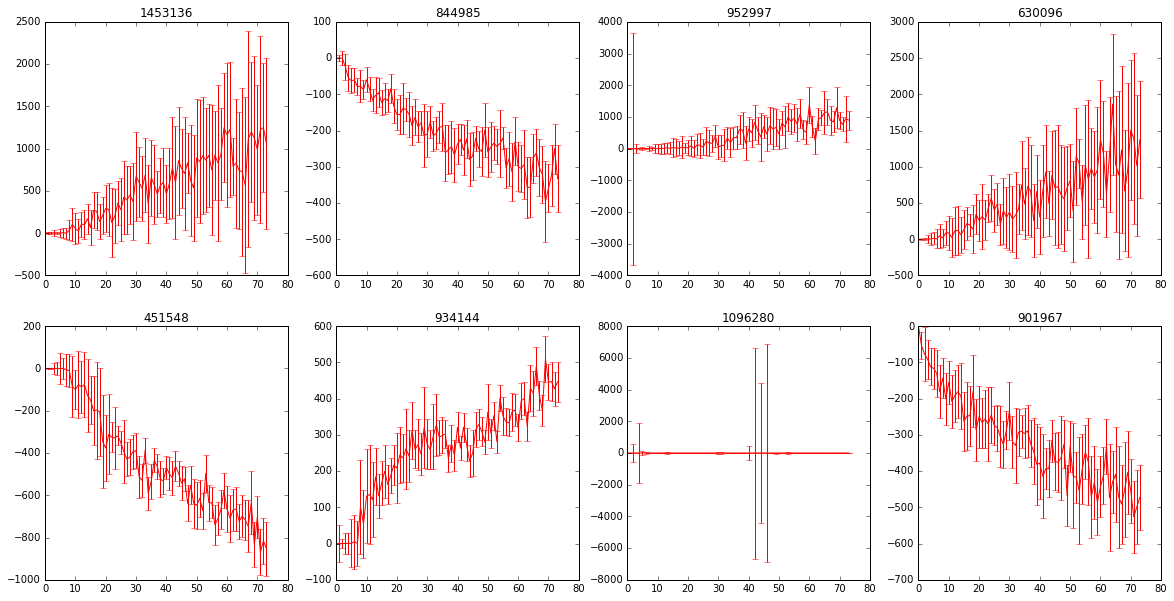

In [22]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as pyplot

sel = np.random.randint(0,len(X_val),size=8)

pyplot.figure(1)

for i in xrange(len(sel)):
    comp = np.reshape(adv_serie_param[:74,sel[i]],[-1, c + 2, m])
    adv_mu_pred = comp[:, :c, :]
    adv_sigma_pred = comp[:, c, :]
    adv_alpha_pred = comp[:, c + 1, :]
    
    ax = pyplot.subplot(2,len(sel)/2,i+1)
    ax.errorbar(np.arange(len(adv_mu_pred)),
                adv_mu_pred.squeeze(),
                yerr=adv_sigma_pred.squeeze(),color='r')
    ax.set_title(str(sel[i]))

pyplot.gcf().set_size_inches((20,10))
pyplot.plot()

[]

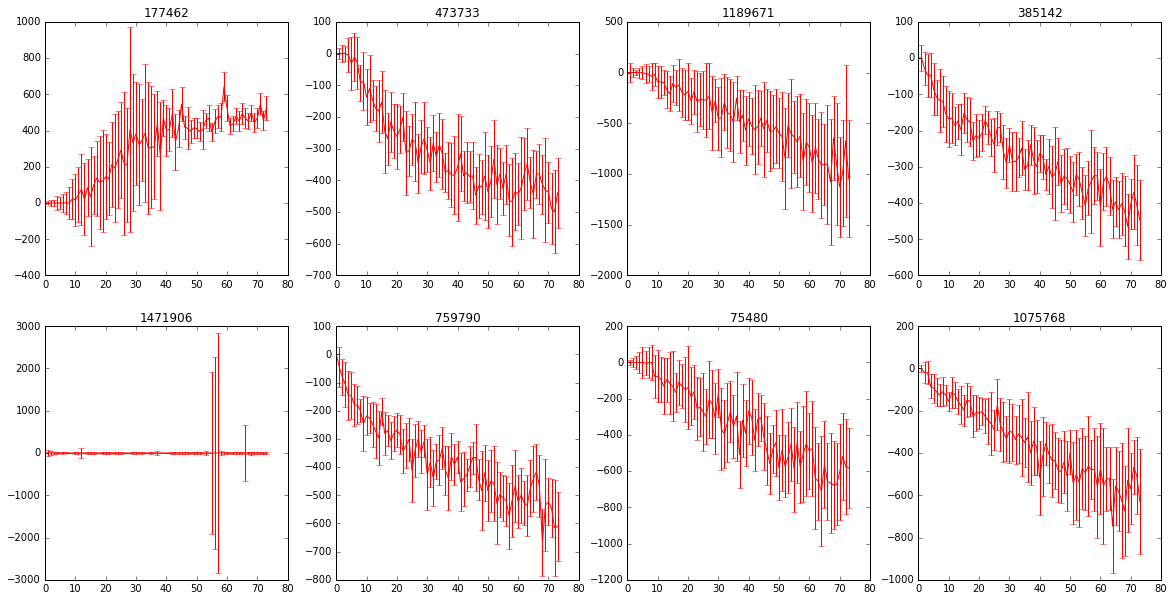

In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as pyplot

sel = np.random.randint(0,len(X_val),size=8)

pyplot.figure(1)

for i in xrange(len(sel)):
    comp = np.reshape(adv_serie_param[:74,sel[i]],[-1, c + 2, m])
    adv_mu_pred = comp[:, :c, :]
    adv_sigma_pred = comp[:, c, :]
    adv_alpha_pred = comp[:, c + 1, :]
    
    ax = pyplot.subplot(2,len(sel)/2,i+1)
    ax.errorbar(np.arange(len(adv_mu_pred)),
                adv_mu_pred.squeeze(),
                yerr=adv_sigma_pred.squeeze(),color='r')
    ax.set_title(str(sel[i]))

pyplot.gcf().set_size_inches((20,10))
pyplot.plot()

[]

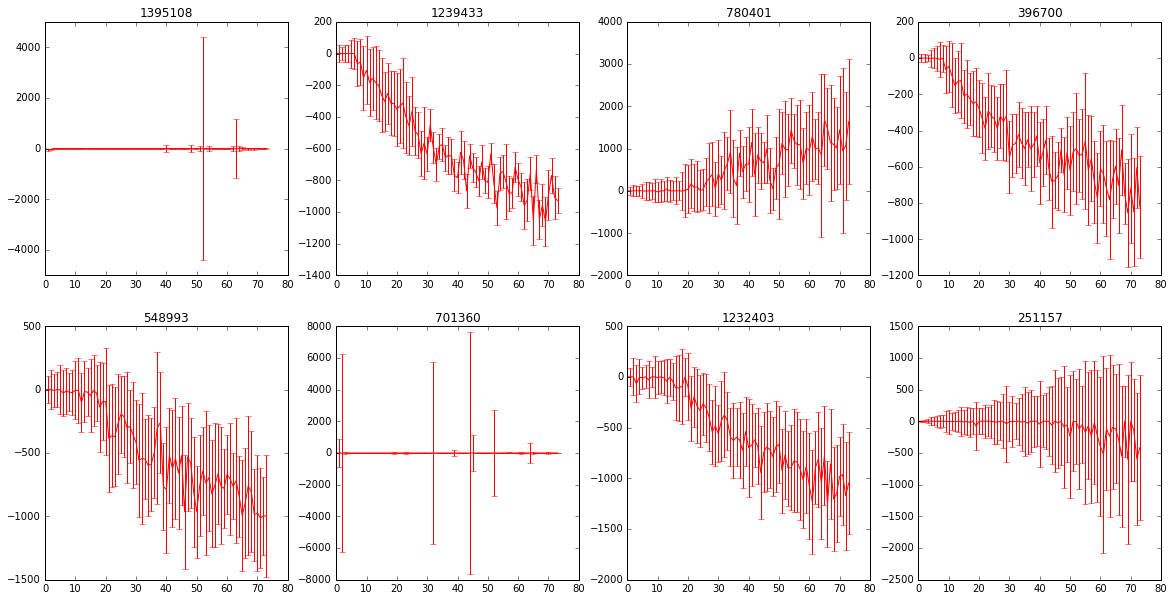

In [24]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as pyplot

sel = np.random.randint(0,len(X_val),size=8)

pyplot.figure(1)

for i in xrange(len(sel)):
    comp = np.reshape(adv_serie_param[:74,sel[i]],[-1, c + 2, m])
    adv_mu_pred = comp[:, :c, :]
    adv_sigma_pred = comp[:, c, :]
    adv_alpha_pred = comp[:, c + 1, :]
    
    ax = pyplot.subplot(2,len(sel)/2,i+1)
    ax.errorbar(np.arange(len(adv_mu_pred)),
                adv_mu_pred.squeeze(),
                yerr=adv_sigma_pred.squeeze(),color='r')
    ax.set_title(str(sel[i]))

pyplot.gcf().set_size_inches((20,10))
pyplot.plot()

[]

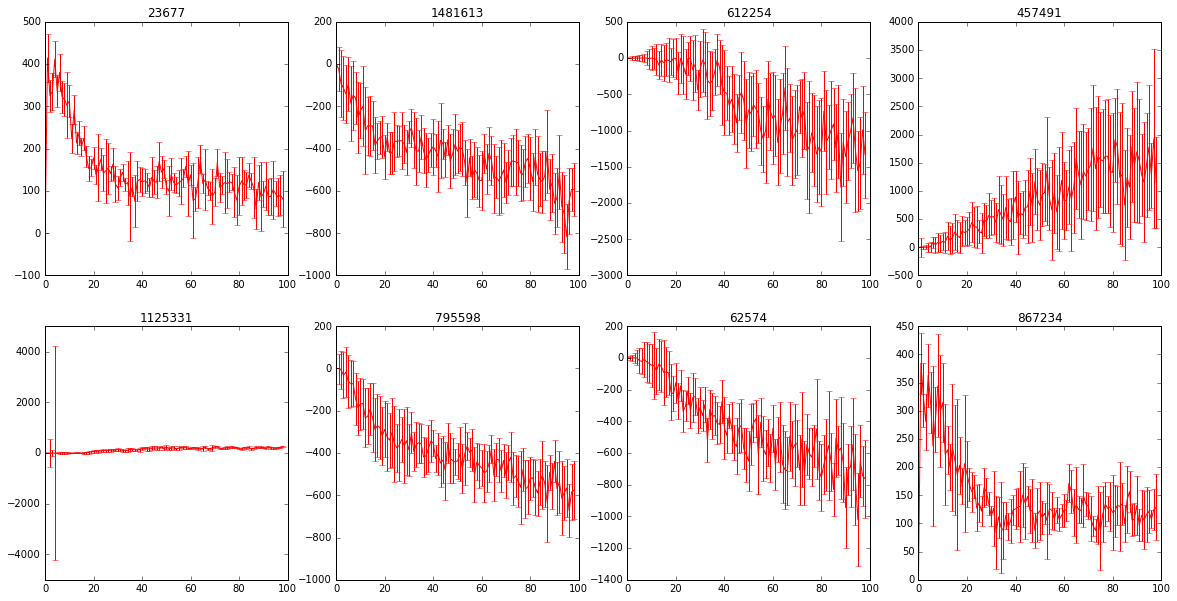

In [26]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as pyplot

sel = np.random.randint(0,len(X_val),size=8)

pyplot.figure(1)

for i in xrange(len(sel)):
    comp = np.reshape(adv_serie_param[:,sel[i]],[-1, c + 2, m])
    adv_mu_pred = comp[:, :c, :]
    adv_sigma_pred = comp[:, c, :]
    adv_alpha_pred = comp[:, c + 1, :]
    
    ax = pyplot.subplot(2,len(sel)/2,i+1)
    ax.errorbar(np.arange(len(adv_mu_pred)),
                adv_mu_pred.squeeze(),
                yerr=adv_sigma_pred.squeeze(),color='r')
    ax.set_title(str(sel[i]))

pyplot.gcf().set_size_inches((20,10))
pyplot.plot()

[]

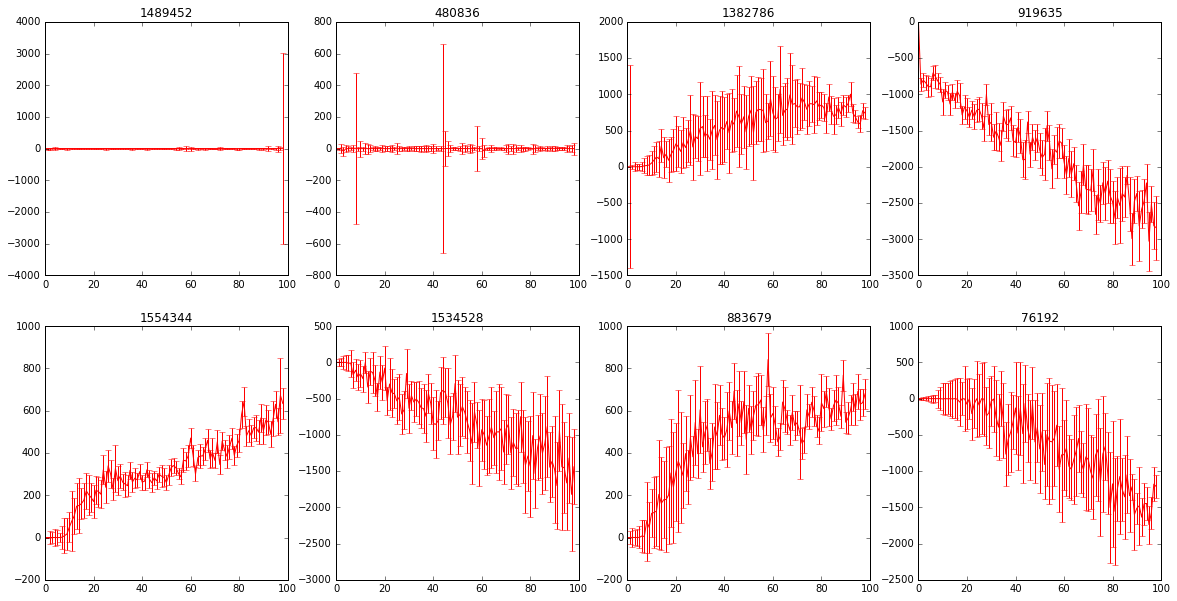

In [27]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as pyplot

sel = np.random.randint(0,len(X_val),size=8)

pyplot.figure(1)

for i in xrange(len(sel)):
    comp = np.reshape(adv_serie_param[:,sel[i]],[-1, c + 2, m])
    adv_mu_pred = comp[:, :c, :]
    adv_sigma_pred = comp[:, c, :]
    adv_alpha_pred = comp[:, c + 1, :]
    
    ax = pyplot.subplot(2,len(sel)/2,i+1)
    ax.errorbar(np.arange(len(adv_mu_pred)),
                adv_mu_pred.squeeze(),
                yerr=adv_sigma_pred.squeeze(),color='r')
    ax.set_title(str(sel[i]))

pyplot.gcf().set_size_inches((20,10))
pyplot.plot()

[]

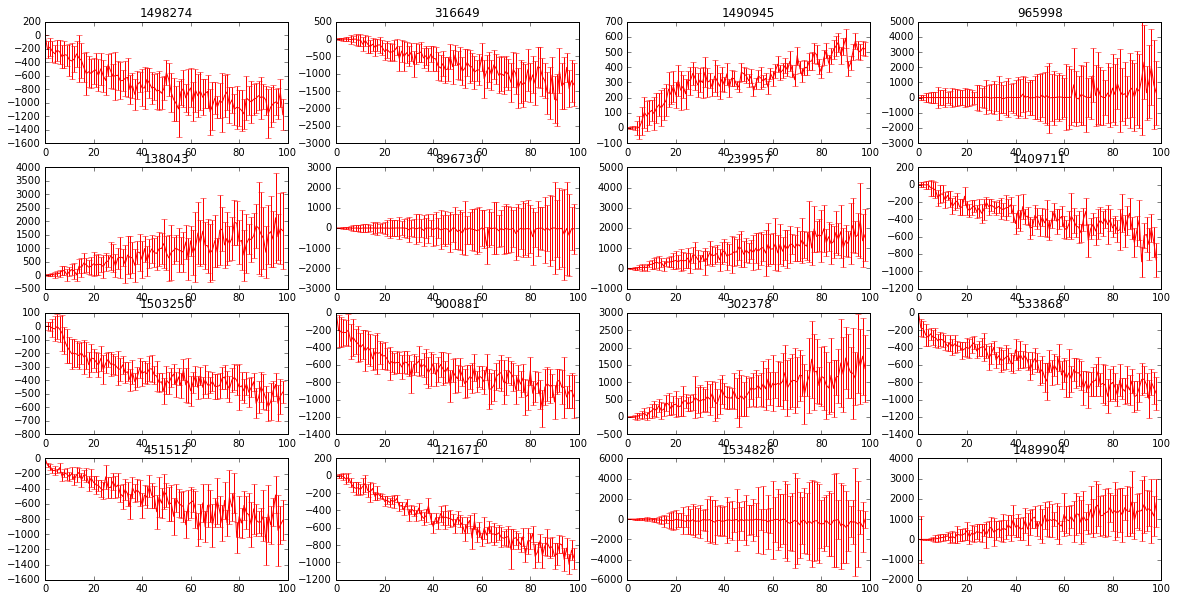

In [30]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as pyplot

sel = np.random.randint(0,len(X_val),size=16)

pyplot.figure(1)

for i in xrange(len(sel)):
    comp = np.reshape(adv_serie_param[:,sel[i]],[-1, c + 2, m])
    adv_mu_pred = comp[:, :c, :]
    adv_sigma_pred = comp[:, c, :]
    adv_alpha_pred = comp[:, c + 1, :]
    
    ax = pyplot.subplot(4,len(sel)/4,i+1)
    ax.errorbar(np.arange(len(adv_mu_pred)),
                adv_mu_pred.squeeze(),
                yerr=adv_sigma_pred.squeeze(),color='r')
    ax.set_title(str(sel[i]))

pyplot.gcf().set_size_inches((20,10))
pyplot.plot()

[]

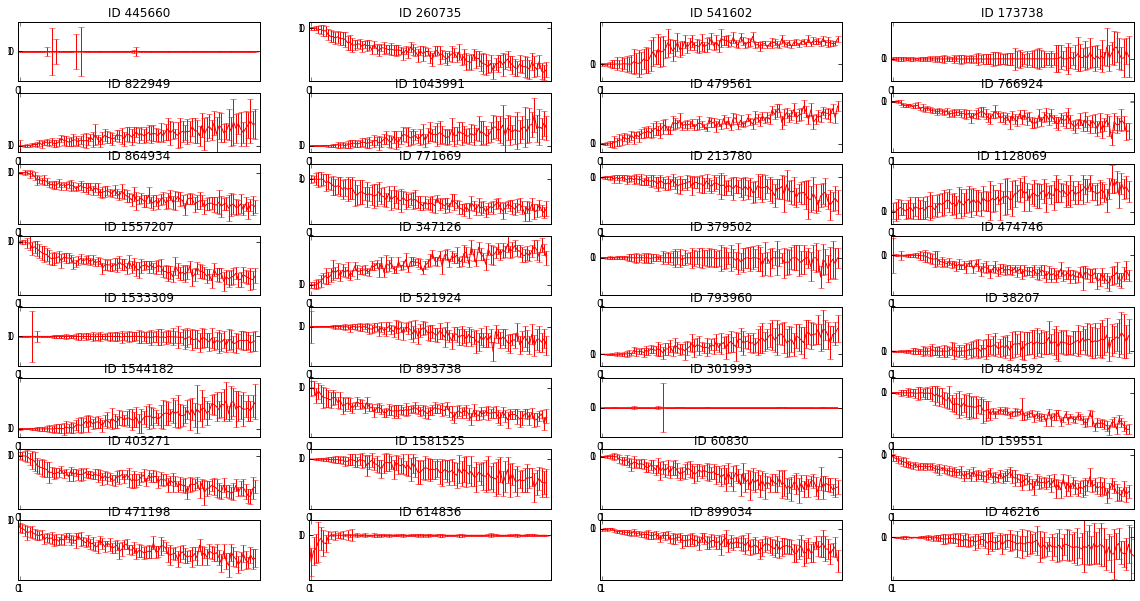

In [35]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as pyplot

sel = np.random.randint(0,len(X_val),size=32)

pyplot.figure(1)

for i in xrange(len(sel)):
    comp = np.reshape(adv_serie_param[:,sel[i]],[-1, c + 2, m])
    adv_mu_pred = comp[:, :c, :]
    adv_sigma_pred = comp[:, c, :]
    adv_alpha_pred = comp[:, c + 1, :]
    
    ax = pyplot.subplot(8,len(sel)/8,i+1)
    ax.errorbar(np.arange(len(adv_mu_pred)),
                adv_mu_pred.squeeze(),
                yerr=adv_sigma_pred.squeeze(),color='r')
    ax.set_title("ID "+str(sel[i]))
    ax.yaxis.set_ticks(range(2))
    ax.xaxis.set_ticks(range(2))

pyplot.gcf().set_size_inches((20,10))
pyplot.plot()

[]

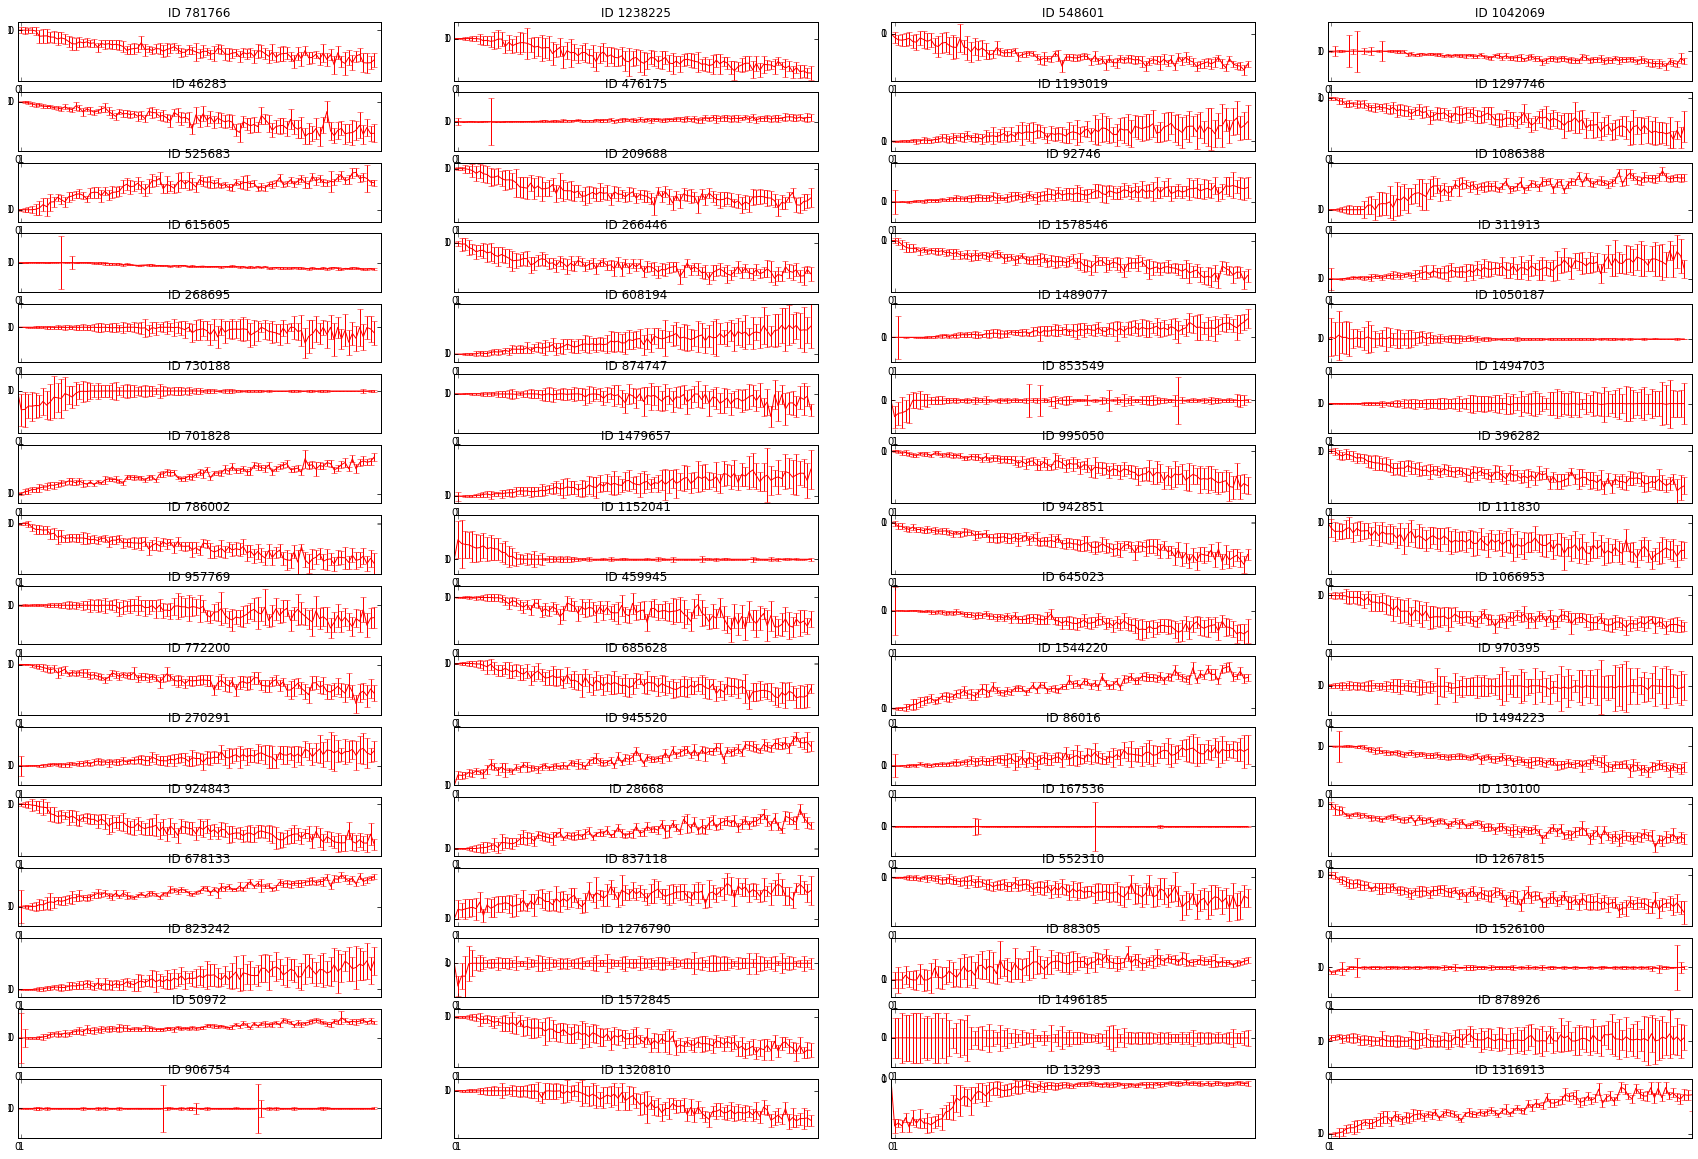

In [39]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as pyplot

sel = np.random.randint(0,len(X_val),size=64)

pyplot.figure(1)

for i in xrange(len(sel)):
    comp = np.reshape(adv_serie_param[:,sel[i]],[-1, c + 2, m])
    adv_mu_pred = comp[:, :c, :]
    adv_sigma_pred = comp[:, c, :]
    adv_alpha_pred = comp[:, c + 1, :]
    
    ax = pyplot.subplot(16,len(sel)/16,i+1)
    ax.errorbar(np.arange(len(adv_mu_pred)),
                adv_mu_pred.squeeze(),
                yerr=adv_sigma_pred.squeeze(),color='r')
    ax.set_title("ID "+str(sel[i]))
    ax.yaxis.set_ticks(range(2))
    ax.xaxis.set_ticks(range(2))

pyplot.gcf().set_size_inches((30,20))
pyplot.plot()

[]

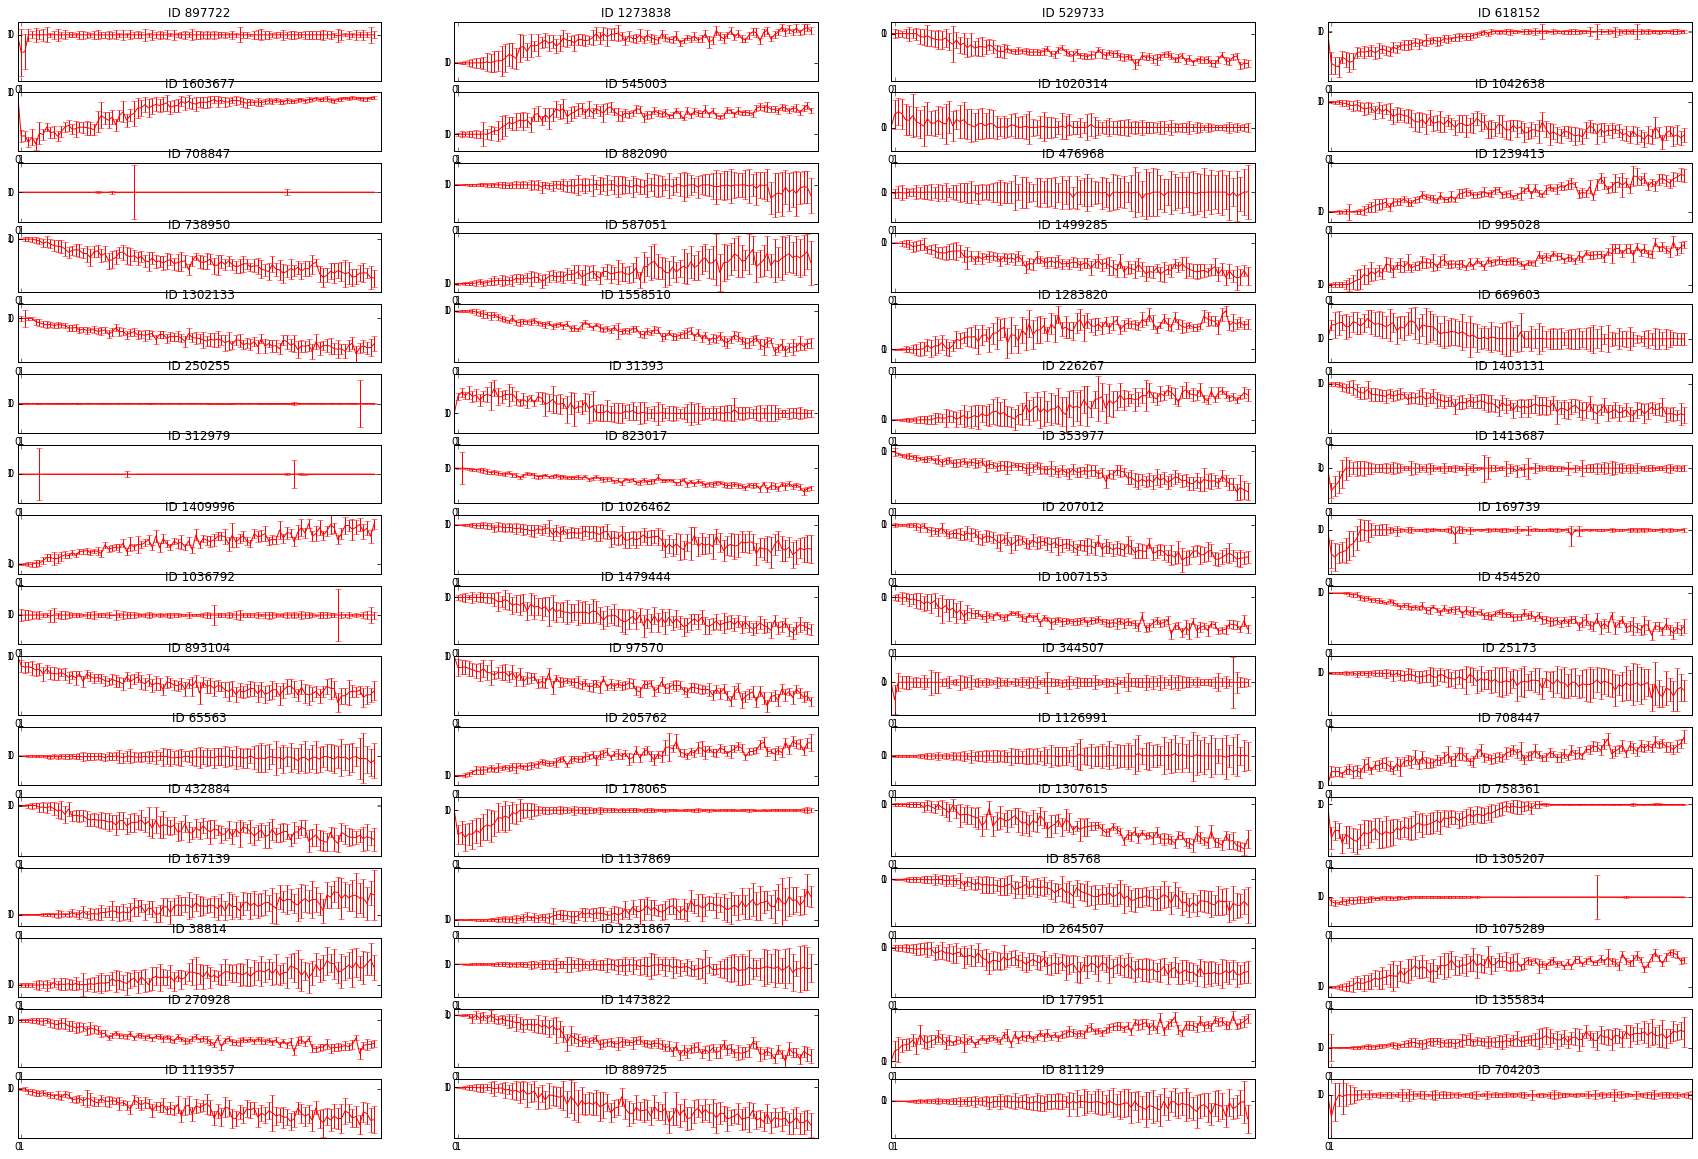

In [40]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as pyplot

sel = np.random.randint(0,len(X_val),size=64)

pyplot.figure(1)

for i in xrange(len(sel)):
    comp = np.reshape(adv_serie_param[:,sel[i]],[-1, c + 2, m])
    adv_mu_pred = comp[:, :c, :]
    adv_sigma_pred = comp[:, c, :]
    adv_alpha_pred = comp[:, c + 1, :]
    
    ax = pyplot.subplot(16,len(sel)/16,i+1)
    ax.errorbar(np.arange(len(adv_mu_pred)),
                adv_mu_pred.squeeze(),
                yerr=adv_sigma_pred.squeeze(),color='r')
    ax.set_title("ID "+str(sel[i]))
    ax.yaxis.set_ticks(range(2))
    ax.xaxis.set_ticks(range(2))

pyplot.gcf().set_size_inches((30,20))
pyplot.plot()

[]

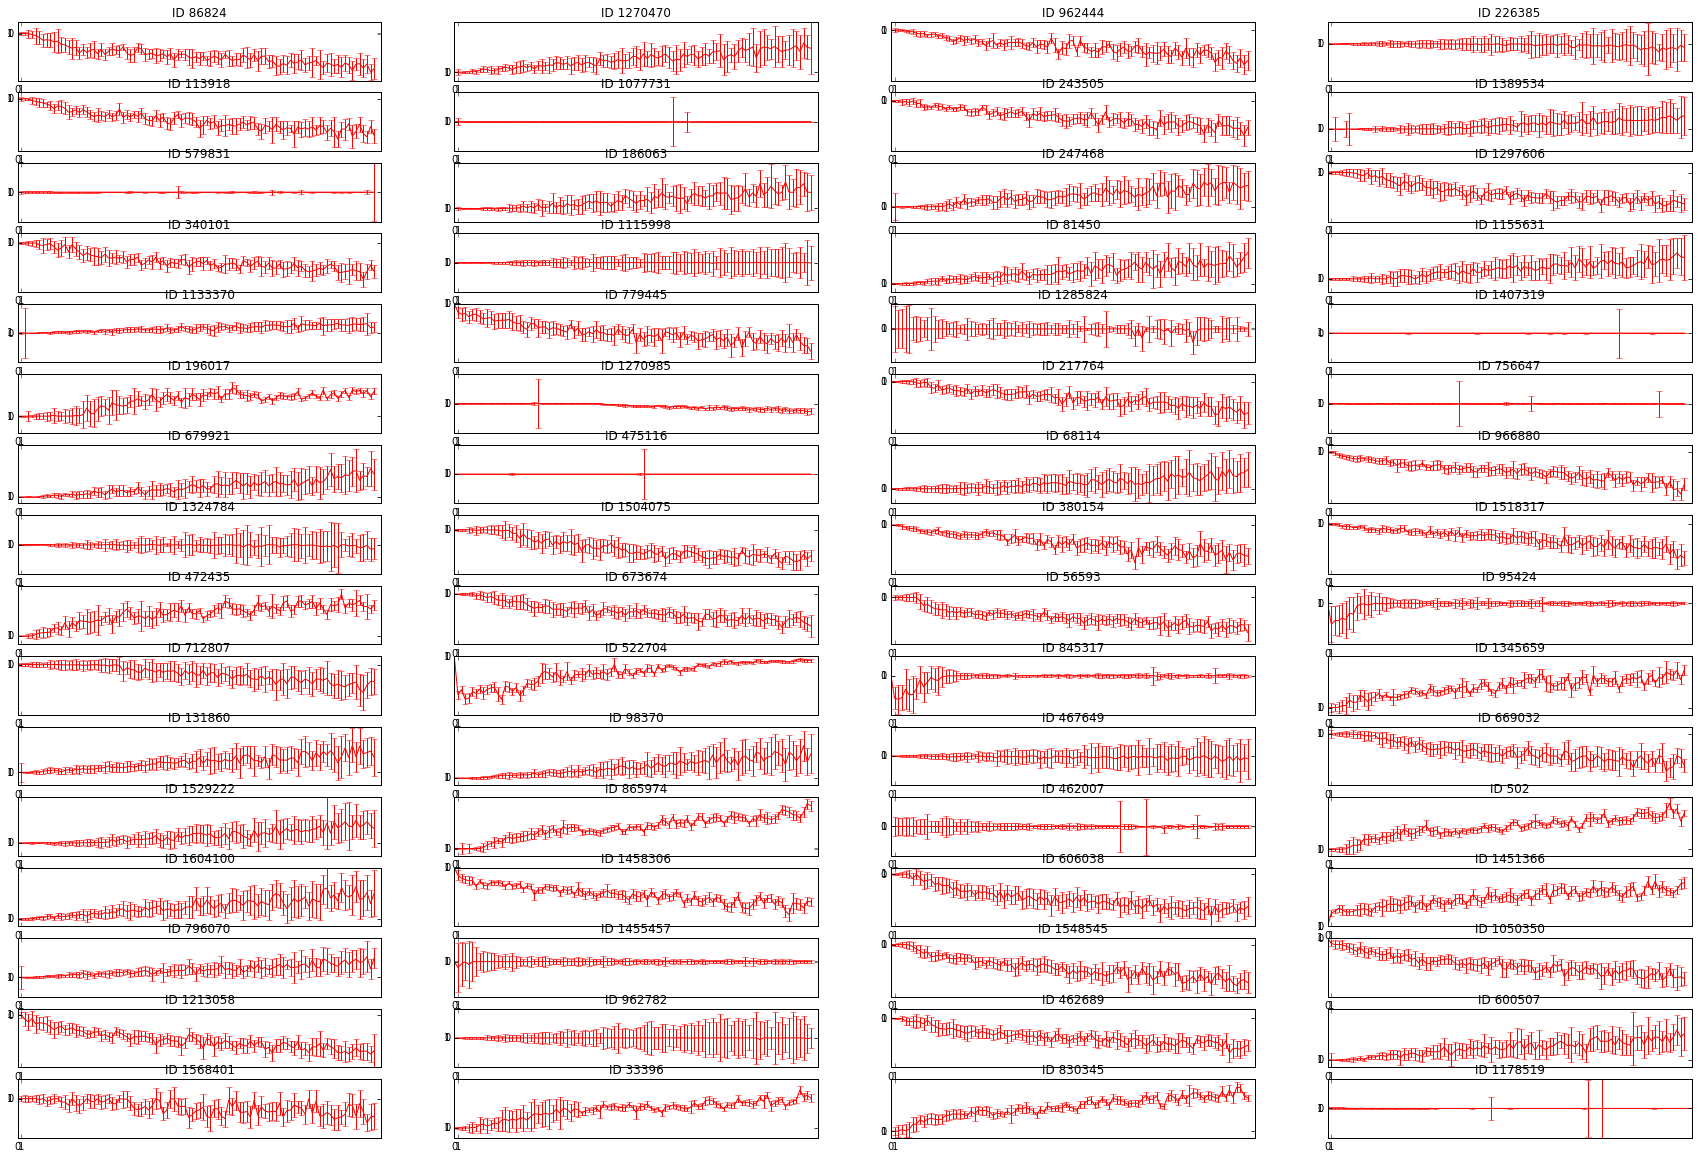

In [42]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as pyplot

sel = np.random.randint(0,len(X_val),size=64)

pyplot.figure(1)

for i in xrange(len(sel)):
    comp = np.reshape(adv_serie_param[:,sel[i]],[-1, c + 2, m])
    adv_mu_pred = comp[:, :c, :]
    adv_sigma_pred = comp[:, c, :]
    adv_alpha_pred = comp[:, c + 1, :]
    
    ax = pyplot.subplot(16,len(sel)/16,i+1)
    ax.errorbar(np.arange(len(adv_mu_pred)),
                adv_mu_pred.squeeze(),
                yerr=adv_sigma_pred.squeeze(),color='r')
    ax.set_title("ID "+str(sel[i]))
    ax.yaxis.set_ticks(range(2))
    ax.xaxis.set_ticks(range(2))

pyplot.gcf().set_size_inches((30,20))
pyplot.plot()

[]

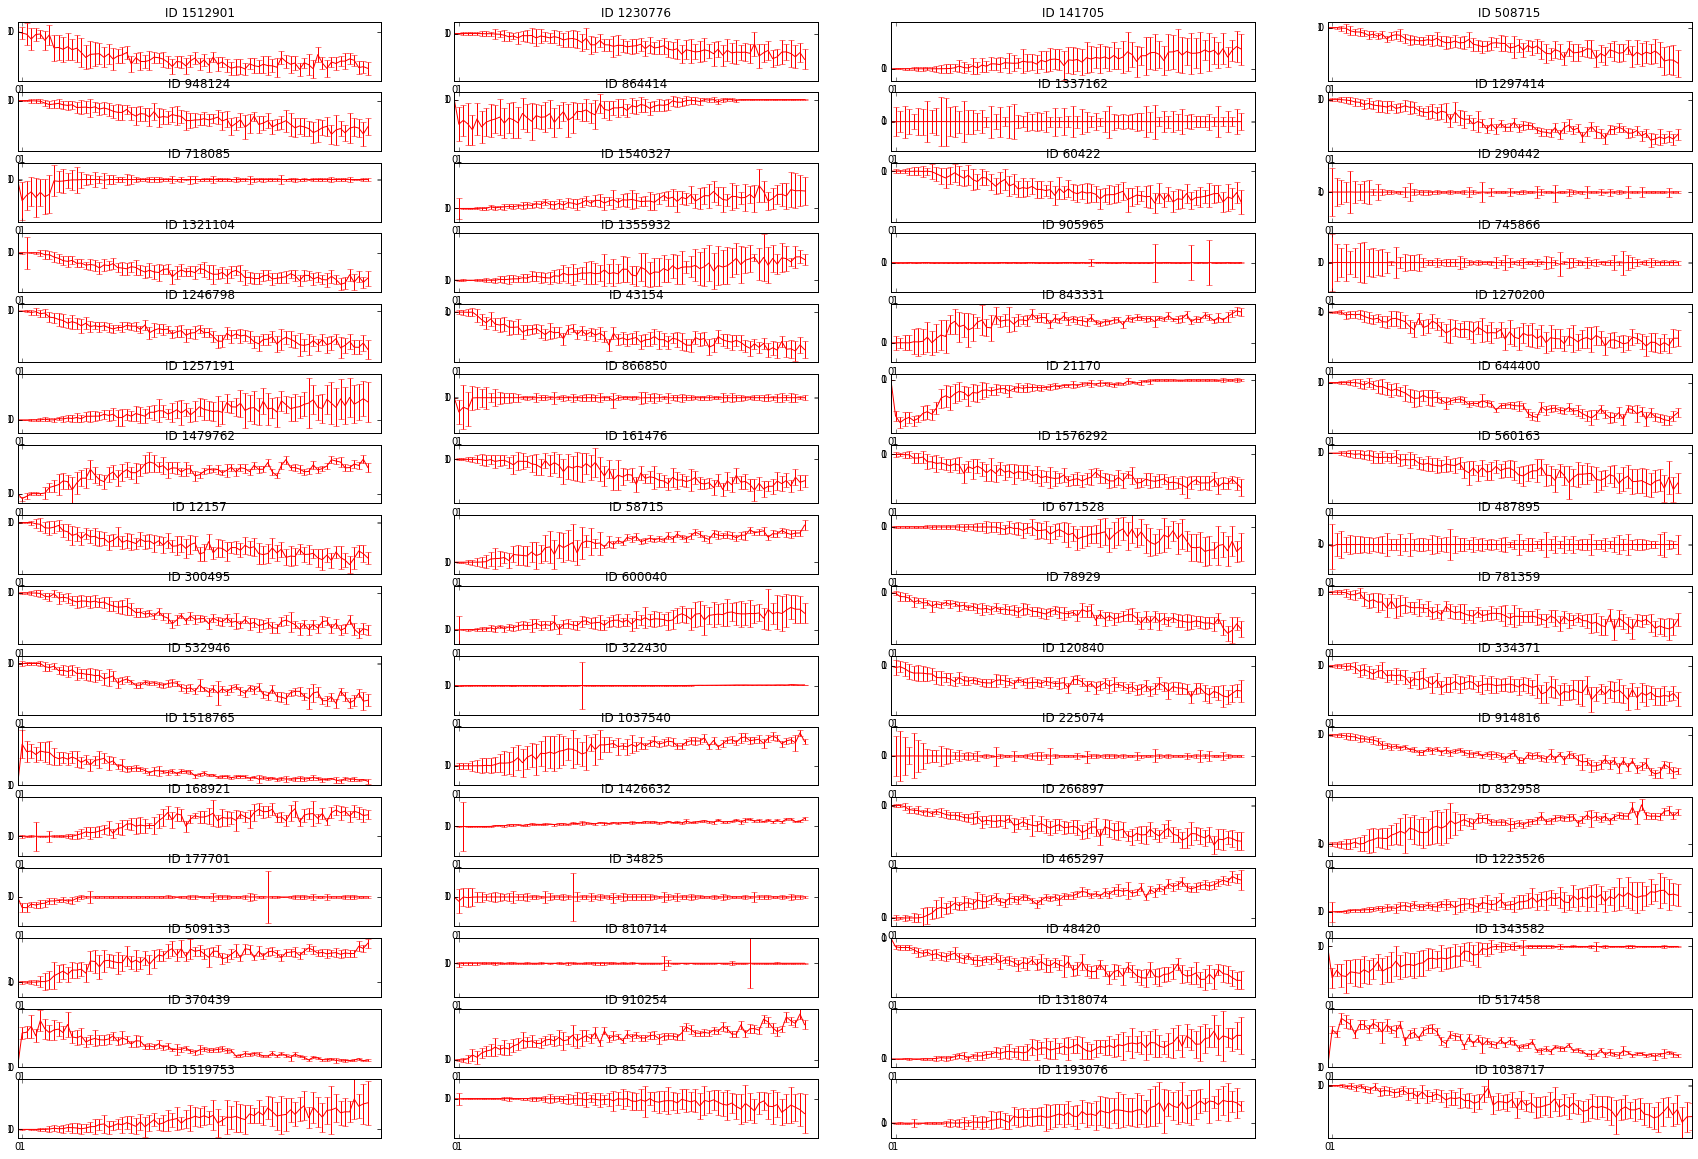

In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as pyplot

sel = np.random.randint(0,len(X_val),size=64)

pyplot.figure(1)

for i in xrange(len(sel)):
    comp = np.reshape(adv_serie_param[:78,sel[i]],[-1, c + 2, m])
    adv_mu_pred = comp[:, :c, :]
    adv_sigma_pred = comp[:, c, :]
    adv_alpha_pred = comp[:, c + 1, :]
    
    ax = pyplot.subplot(16,len(sel)/16,i+1)
    ax.errorbar(np.arange(len(adv_mu_pred[:78])),
                adv_mu_pred.squeeze(),
                yerr=adv_sigma_pred.squeeze(),color='r')
    ax.set_title("ID "+str(sel[i]))
    ax.yaxis.set_ticks(range(2))
    ax.xaxis.set_ticks(range(2))

pyplot.gcf().set_size_inches((30,20))
pyplot.plot()

## Evolution of the sum of all the $\sigma$s of the data set each step.

In [40]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as pyplot
from matplotlib import lines

In [9]:
lst = []
for step in tqdm(xrange(1,adv_steps-1)):
    lst += [np.reshape(adv_serie_param[step],[-1, c + 2, m])[:, c, :].sum()]

100%|██████████| 98/98 [01:16<00:00,  1.02s/it]


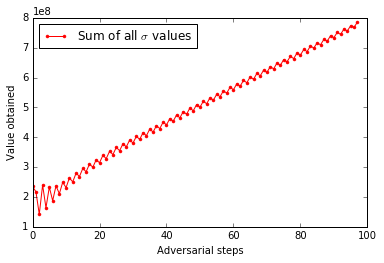

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline


fig = plt.figure()

ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)

ax.set_xlabel('Adversarial steps')
ax.set_ylabel('Value obtained')

ax.plot(lst, marker='.', label='Sum of all $\sigma$ values', color='r')

ax.legend(loc=2)
plt.show()

In [7]:
lst = []
for step in tqdm(xrange(1,74)):
    lst += [np.reshape(adv_serie_param[step],[-1, c + 2, m])[:, c, :].sum()]

100%|██████████| 73/73 [03:38<00:00,  4.08s/it]


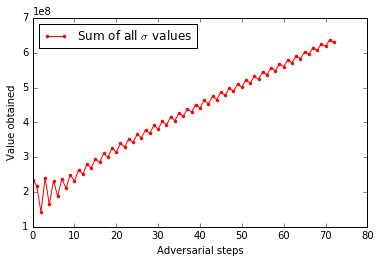

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline


fig = plt.figure()
#fig.suptitle('bold figure suptitle', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
#ax.set_title('axes title')

ax.set_xlabel('Adversarial steps')
ax.set_ylabel('Value obtained')

ax.plot(lst, marker='.', label='Sum of all $\sigma$ values', color='r')

ax.legend(loc=2)
plt.show()